In [2]:
import numpy as np
import scipy
import sys
import os
import optuna

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from LSPIN_model import Model
from utils import DataSet

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

### Linear synthetic data generation

Group 1: $X$ ~ $N(1,0.5)$,  $Y = -2X_1 + X_2 - 0.5X_3$

Group 2: $X$ ~ $N(-1,0.5)$, $Y = -0.5X_3 + X_4 - 2X_5$



In [4]:
np.random.seed(34)

Xs1 = np.random.normal(loc=1,scale=0.5,size=(300,5))
Ys1 = -2*Xs1[:,0]+1*Xs1[:,1]-0.5*Xs1[:,2]

Xs2 = np.random.normal(loc=-1,scale=0.5,size=(300,5))
Ys2 = -0.5*Xs2[:,2]+1*Xs2[:,3]-2*Xs2[:,4]

In [5]:
X_data = np.concatenate((Xs1,Xs2),axis=0)
Y_data = np.concatenate((Ys1.reshape(-1,1),Ys2.reshape(-1,1)),axis=0)

In [6]:
Y_data = Y_data-Y_data.min()
Y_data=Y_data/Y_data.max()

In [7]:
# The ground truth group label of each sample
case_labels = np.concatenate((np.array([1]*300),np.array([2]*300)))

In [8]:
Y_data = np.concatenate((Y_data,case_labels.reshape(-1,1)),axis=1)

In [9]:
# 10% for validation, 10% for test 
X_train,X_remain,yc_train,yc_remain = train_test_split(X_data,Y_data,train_size=0.8,shuffle=True,random_state=34)
X_valid,X_test,yc_valid,yc_test = train_test_split(X_remain,yc_remain,train_size=0.5,shuffle=True,random_state=34)

In [10]:
# Only 10 samples used for training
X_train,_,yc_train,_ = train_test_split(X_train,yc_train,train_size=10,shuffle=True,random_state=34)

In [11]:
print("Sample sizes:")
print(X_train.shape[0],X_valid.shape[0],X_test.shape[0])

Sample sizes:
10 60 60


In [12]:
y_train = yc_train[:,0].reshape(-1,1)
y_valid = yc_valid[:,0].reshape(-1,1)
y_test = yc_test[:,0].reshape(-1,1)

In [13]:
train_label = yc_train[:,1]
valid_label = yc_valid[:,1]
test_label= yc_test[:,1]

In [14]:
from collections import Counter
Counter(train_label)

Counter({2.0: 6, 1.0: 4})

In [15]:
Counter(valid_label)

Counter({2.0: 29, 1.0: 31})

In [16]:
dataset = DataSet(**{'_data':X_train, '_labels':y_train,
                '_valid_data':X_valid, '_valid_labels':y_valid,
                '_test_data':X_test, '_test_labels':y_test})

In [17]:
# reference ground truth feature matrix (training/test)
ref_feat_mat_train = np.array([[1,1,1,0,0] if label == 1 else [0,0,1,1,1] for label in train_label])
ref_feat_mat_test = np.array([[1,1,1,0,0] if label == 1 else [0,0,1,1,1] for label in test_label])

### LLSPIN

In [18]:
def llspin_objective(trial):  
    global model
            
    params = {
        "feature_selection" : True,
        "sigma" : 0.5,
        "display_step" : 500,
        "hidden_layers_node" : [100,100,10,10],
        "batch_normalization": True,
        "input_node" : X_train.shape[1],
        "output_node" : 1
    }
    params['stddev_input'] = 0.1 
    params['activation']= 'none'
    params['batch_size']= X_train.shape[0]
    params['feature_selection_dimension']=[10]
    params['lam'] = trial.suggest_loguniform('lam',1e-3,1e-2)
    params['learning_rate'] = trial.suggest_loguniform('learning_rate', 1e-2, 2e-1)
    num_epoch = trial.suggest_categorical('num_epoch', [2000,5000,10000,15000])

    model_dir =None
    model = Model(**params)
    train_acces, train_losses, val_acces, val_losses = model.train(trial, dataset, model_dir, num_epoch=num_epoch)

    print("In trial:---------------------")
    val_prediction = model.test(X_valid)[0]
    mse = mean_squared_error(y_valid.reshape(-1),val_prediction.reshape(-1))
    print("validation mse: {}".format(mse))
    
    loss= mse
            
    return loss
        
def callback(study,trial):
    global best_model
    if study.best_trial == trial:
        best_model = model

In [19]:
best_model = None
model = None
study = optuna.create_study(pruner=None)
study.optimize(llspin_objective, n_trials=100, callbacks=[callback])

[I 2021-06-07 21:23:36,862] A new study created in memory with name: no-name-bbdf7d45-4091-4016-8979-e26e34531d5e








Instructions for updating:
Use keras.layers.BatchNormalization instead.  In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.batch_normalization` documentation).
Instructions for updating:
Please use `layer.__call__` method instead.





Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



num_samples : 10
Epoch: 500 train loss=0.013654673 valid loss= 0.010960348
train reg_fs: 0.004589471034705639
Epoch: 1000 train loss=0.013338368 valid loss= 0.010577765
train reg_fs: 0.004532516002655029
Epoch: 1500 train loss=0.017317429 valid loss= 0.008848630
train reg_fs: 0.004269345663487911


[I 2021-06-07 21:23:51,955] Trial 0 finished with value: 0.0024490264889776097 and parameters: {'lam': 0.00532267568840898, 'learning_rate': 0.08947279355685521, 'num_epoch': 2000}. Best is trial 0 with value: 0.0024490264889776097.


Epoch: 2000 train loss=0.007848827 valid loss= 0.006619227
train reg_fs: 0.0040261694230139256
Optimization Finished!
test loss: 0.007254479452967644, test acc: 1.0
In trial:---------------------
validation mse: 0.0024490264889776097
num_samples : 10
Epoch: 500 train loss=0.017422628 valid loss= 0.007202836
train reg_fs: 0.001364467665553093
Epoch: 1000 train loss=0.012376026 valid loss= 0.006976860
train reg_fs: 0.001377518055960536
Epoch: 1500 train loss=0.012448343 valid loss= 0.006879329
train reg_fs: 0.001365547883324325
Epoch: 2000 train loss=0.007617533 valid loss= 0.006667621
train reg_fs: 0.0013390748063102365
Epoch: 2500 train loss=0.004368822 valid loss= 0.005228508
train reg_fs: 0.001314297434873879
Epoch: 3000 train loss=0.010911244 valid loss= 0.005350078
train reg_fs: 0.001288883970119059
Epoch: 3500 train loss=0.004816992 valid loss= 0.004510775
train reg_fs: 0.0012646423419937491
Epoch: 4000 train loss=0.004171397 valid loss= 0.003891933
train reg_fs: 0.001242821221239

[I 2021-06-07 21:24:54,791] Trial 1 finished with value: 0.0030776548926728974 and parameters: {'lam': 0.0015847007688429597, 'learning_rate': 0.050162692182846615, 'num_epoch': 10000}. Best is trial 0 with value: 0.0024490264889776097.


Epoch: 10000 train loss=0.002317862 valid loss= 0.004283225
train reg_fs: 0.0011795706814154983
Optimization Finished!
test loss: 0.0041567618027329445, test acc: 1.0
In trial:---------------------
validation mse: 0.0030776548926728974
num_samples : 10
Epoch: 500 train loss=0.016085166 valid loss= 0.011680217
train reg_fs: 0.005085580516606569
Epoch: 1000 train loss=0.013016795 valid loss= 0.012555476
train reg_fs: 0.00504174642264843
Epoch: 1500 train loss=0.010339711 valid loss= 0.011523009
train reg_fs: 0.004947894252836704


[I 2021-06-07 21:25:08,922] Trial 2 finished with value: 0.004437518656664881 and parameters: {'lam': 0.006043842962965929, 'learning_rate': 0.04177084602900404, 'num_epoch': 2000}. Best is trial 0 with value: 0.0024490264889776097.


Epoch: 2000 train loss=0.011620639 valid loss= 0.009446233
train reg_fs: 0.0048494525253772736
Optimization Finished!
test loss: 0.011262528598308563, test acc: 1.0
In trial:---------------------
validation mse: 0.004437518656664881
num_samples : 10
Epoch: 500 train loss=0.012341027 valid loss= 0.008414185
train reg_fs: 0.0011531751370057464
Epoch: 1000 train loss=0.006680239 valid loss= 0.007961732
train reg_fs: 0.0011756602907553315
Epoch: 1500 train loss=0.018868905 valid loss= 0.006327592
train reg_fs: 0.0011887582950294018
Epoch: 2000 train loss=0.006362008 valid loss= 0.007906013
train reg_fs: 0.0011974774533882737
Epoch: 2500 train loss=0.007726546 valid loss= 0.007184912
train reg_fs: 0.001202726038172841
Epoch: 3000 train loss=0.007300777 valid loss= 0.006286074
train reg_fs: 0.0012073674006387591
Epoch: 3500 train loss=0.007936542 valid loss= 0.006283639
train reg_fs: 0.001209284644573927
Epoch: 4000 train loss=0.006430004 valid loss= 0.006503778
train reg_fs: 0.0012103611370

[I 2021-06-07 21:26:14,292] Trial 3 finished with value: 0.0030847921086823134 and parameters: {'lam': 0.0013287958195412602, 'learning_rate': 0.04627147388379551, 'num_epoch': 10000}. Best is trial 0 with value: 0.0024490264889776097.


Epoch: 10000 train loss=0.004637146 valid loss= 0.004252792
train reg_fs: 0.0011729757534340024
Optimization Finished!
test loss: 0.004773435648530722, test acc: 1.0
In trial:---------------------
validation mse: 0.0030847921086823134
num_samples : 10
Epoch: 500 train loss=0.003100527 valid loss= 0.007153228
train reg_fs: 0.0009049674263224006
Epoch: 1000 train loss=0.009211808 valid loss= 0.005435642
train reg_fs: 0.0008527980535291135
Epoch: 1500 train loss=0.003527853 valid loss= 0.004942952
train reg_fs: 0.0008183852769434452
Epoch: 2000 train loss=0.005056193 valid loss= 0.003971014
train reg_fs: 0.0008058950188569725
Epoch: 2500 train loss=0.003169697 valid loss= 0.004464900
train reg_fs: 0.0007986717973835766
Epoch: 3000 train loss=0.002493702 valid loss= 0.004485914
train reg_fs: 0.0007933845045045018
Epoch: 3500 train loss=0.009999719 valid loss= 0.005719044
train reg_fs: 0.0007874430739320815
Epoch: 4000 train loss=0.001766008 valid loss= 0.005051428
train reg_fs: 0.000774615

[I 2021-06-07 21:26:48,349] Trial 4 finished with value: 0.00303398544763466 and parameters: {'lam': 0.0010698288836695298, 'learning_rate': 0.10624157029791992, 'num_epoch': 5000}. Best is trial 0 with value: 0.0024490264889776097.


Epoch: 5000 train loss=0.002332649 valid loss= 0.003776201
train reg_fs: 0.0007447952521033585
Optimization Finished!
test loss: 0.0033340957015752792, test acc: 1.0
In trial:---------------------
validation mse: 0.00303398544763466
num_samples : 10
Epoch: 500 train loss=0.015695347 valid loss= 0.008120083
train reg_fs: 0.0017591669457033277
Epoch: 1000 train loss=0.016769735 valid loss= 0.008355604
train reg_fs: 0.0017558218678459525
Epoch: 1500 train loss=0.012866656 valid loss= 0.006170876
train reg_fs: 0.0017062922706827521
Epoch: 2000 train loss=0.006129302 valid loss= 0.004641738
train reg_fs: 0.0016461575869470835
Epoch: 2500 train loss=0.004336464 valid loss= 0.003556177
train reg_fs: 0.0015940675511956215
Epoch: 3000 train loss=0.002323070 valid loss= 0.003165871
train reg_fs: 0.0015523415058851242
Epoch: 3500 train loss=0.004278734 valid loss= 0.004373170
train reg_fs: 0.0015256261685863137
Epoch: 4000 train loss=0.003915407 valid loss= 0.003485736
train reg_fs: 0.00150787224

[I 2021-06-07 21:27:55,440] Trial 5 finished with value: 0.0013449369208300905 and parameters: {'lam': 0.0020251297040490028, 'learning_rate': 0.07422016152094056, 'num_epoch': 10000}. Best is trial 5 with value: 0.0013449369208300905.


Epoch: 10000 train loss=0.003394773 valid loss= 0.002808537
train reg_fs: 0.001398230204358697
Optimization Finished!
test loss: 0.0035070471931248903, test acc: 1.0
In trial:---------------------
validation mse: 0.0013449369208300905
num_samples : 10
Epoch: 500 train loss=0.011844113 valid loss= 0.009296048
train reg_fs: 0.0016120241489261389
Epoch: 1000 train loss=0.010543466 valid loss= 0.008134441
train reg_fs: 0.0016328786732628942
Epoch: 1500 train loss=0.008933723 valid loss= 0.008294631
train reg_fs: 0.0016483638901263475
Epoch: 2000 train loss=0.014679698 valid loss= 0.008634226
train reg_fs: 0.0016579811926931143
Epoch: 2500 train loss=0.010948313 valid loss= 0.007400280
train reg_fs: 0.0016638687811791897
Epoch: 3000 train loss=0.008729324 valid loss= 0.007017517
train reg_fs: 0.001665027579292655
Epoch: 3500 train loss=0.018675754 valid loss= 0.006866698
train reg_fs: 0.0016635643551126122
Epoch: 4000 train loss=0.009838231 valid loss= 0.006989758
train reg_fs: 0.0016595681

[I 2021-06-07 21:29:01,818] Trial 6 finished with value: 0.0028333605732889537 and parameters: {'lam': 0.0018953900323618364, 'learning_rate': 0.022687623217388826, 'num_epoch': 10000}. Best is trial 5 with value: 0.0013449369208300905.


Epoch: 10000 train loss=0.003322606 valid loss= 0.004429672
train reg_fs: 0.0015728181460872293
Optimization Finished!
test loss: 0.005282490514218807, test acc: 1.0
In trial:---------------------
validation mse: 0.0028333605732889537
num_samples : 10
Epoch: 500 train loss=0.009452423 valid loss= 0.006727871
train reg_fs: 0.000939234858378768
Epoch: 1000 train loss=0.010419076 valid loss= 0.008139777
train reg_fs: 0.0009263556567020714
Epoch: 1500 train loss=0.011830965 valid loss= 0.006261185
train reg_fs: 0.0009008086053654552


[I 2021-06-07 21:29:16,020] Trial 7 finished with value: 0.00667442216418122 and parameters: {'lam': 0.001068452421543597, 'learning_rate': 0.11929847123108774, 'num_epoch': 2000}. Best is trial 5 with value: 0.0013449369208300905.


Epoch: 2000 train loss=0.004995606 valid loss= 0.007580666
train reg_fs: 0.0008851818274706602
Optimization Finished!
test loss: 0.0070760175585746765, test acc: 1.0
In trial:---------------------
validation mse: 0.00667442216418122
num_samples : 10
Epoch: 500 train loss=0.016297694 valid loss= 0.014916880
train reg_fs: 0.006747206673026085
Epoch: 1000 train loss=0.016916536 valid loss= 0.015309377
train reg_fs: 0.0066306679509580135
Epoch: 1500 train loss=0.012544040 valid loss= 0.013639046
train reg_fs: 0.006446318235248327


[I 2021-06-07 21:29:30,057] Trial 8 finished with value: 0.006123665788000255 and parameters: {'lam': 0.007954593600689374, 'learning_rate': 0.0741101488195815, 'num_epoch': 2000}. Best is trial 5 with value: 0.0013449369208300905.


Epoch: 2000 train loss=0.012579444 valid loss= 0.012581348
train reg_fs: 0.006278757471591234
Optimization Finished!
test loss: 0.01333106029778719, test acc: 1.0
In trial:---------------------
validation mse: 0.006123665788000255
num_samples : 10
Epoch: 500 train loss=0.008174803 valid loss= 0.007042373
train reg_fs: 0.0011941310949623585
Epoch: 1000 train loss=0.005637000 valid loss= 0.005899456
train reg_fs: 0.0011716425651684403
Epoch: 1500 train loss=0.005732570 valid loss= 0.006085094
train reg_fs: 0.0011415713233873248
Epoch: 2000 train loss=0.007186696 valid loss= 0.004208722
train reg_fs: 0.0011175295803695917
Epoch: 2500 train loss=0.004132164 valid loss= 0.003318559
train reg_fs: 0.0010869152611121535
Epoch: 3000 train loss=0.003125550 valid loss= 0.003064306
train reg_fs: 0.0010597059736028314
Epoch: 3500 train loss=0.003421918 valid loss= 0.002960507
train reg_fs: 0.0010408175876364112
Epoch: 4000 train loss=0.004788575 valid loss= 0.003302841
train reg_fs: 0.0010252415668

[I 2021-06-07 21:31:03,452] Trial 9 finished with value: 0.002185648823010055 and parameters: {'lam': 0.0013502203696489916, 'learning_rate': 0.12254710694468966, 'num_epoch': 15000}. Best is trial 5 with value: 0.0013449369208300905.


Epoch: 15000 train loss=0.002348130 valid loss= 0.003085067
train reg_fs: 0.0009296126663684845
Optimization Finished!
test loss: 0.0033941762521862984, test acc: 1.0
In trial:---------------------
validation mse: 0.002185648823010055
num_samples : 10
Epoch: 500 train loss=0.010736211 valid loss= 0.009270512
train reg_fs: 0.002666445216163993
Epoch: 1000 train loss=0.011276707 valid loss= 0.008049818
train reg_fs: 0.002586519345641136
Epoch: 1500 train loss=0.010776542 valid loss= 0.006702060
train reg_fs: 0.002468751510605216
Epoch: 2000 train loss=0.003830663 valid loss= 0.004919791
train reg_fs: 0.002420875011011958
Epoch: 2500 train loss=0.005865819 valid loss= 0.005489463
train reg_fs: 0.0023706117644906044
Epoch: 3000 train loss=0.006671987 valid loss= 0.004899985
train reg_fs: 0.0023159978445619345
Epoch: 3500 train loss=0.002586711 valid loss= 0.005110247
train reg_fs: 0.0022671285551041365
Epoch: 4000 train loss=0.003927934 valid loss= 0.004919391
train reg_fs: 0.0022179929073

[I 2021-06-07 21:32:09,133] Trial 10 finished with value: 0.0031430992921248446 and parameters: {'lam': 0.0029790218096502116, 'learning_rate': 0.19621225329675504, 'num_epoch': 10000}. Best is trial 5 with value: 0.0013449369208300905.


Epoch: 10000 train loss=0.004616794 valid loss= 0.005045074
train reg_fs: 0.001958562759682536
Optimization Finished!
test loss: 0.005586166866123676, test acc: 1.0
In trial:---------------------
validation mse: 0.0031430992921248446
num_samples : 10
Epoch: 500 train loss=0.011433396 valid loss= 0.008506509
train reg_fs: 0.0019202798139303923
Epoch: 1000 train loss=0.009933736 valid loss= 0.004574539
train reg_fs: 0.0017223363975062966
Epoch: 1500 train loss=0.004923693 valid loss= 0.005297045
train reg_fs: 0.0016561916563659906
Epoch: 2000 train loss=0.005212095 valid loss= 0.004775051
train reg_fs: 0.0016243919963017106
Epoch: 2500 train loss=0.006356430 valid loss= 0.004971261
train reg_fs: 0.001599034876562655
Epoch: 3000 train loss=0.005815464 valid loss= 0.007690826
train reg_fs: 0.0015749555313959718
Epoch: 3500 train loss=0.004358225 valid loss= 0.005519967
train reg_fs: 0.0015531884273514152
Epoch: 4000 train loss=0.006243575 valid loss= 0.005062880
train reg_fs: 0.00153520121

[I 2021-06-07 21:33:46,416] Trial 11 finished with value: 0.003963675590550313 and parameters: {'lam': 0.002353774245521596, 'learning_rate': 0.1974006885695881, 'num_epoch': 15000}. Best is trial 5 with value: 0.0013449369208300905.


Epoch: 15000 train loss=0.002134998 valid loss= 0.005458714
train reg_fs: 0.001452022697776556
Optimization Finished!
test loss: 0.005871794186532497, test acc: 1.0
In trial:---------------------
validation mse: 0.003963675590550313
num_samples : 10
Epoch: 500 train loss=0.012367727 valid loss= 0.008432356
train reg_fs: 0.0018509217770770192
Epoch: 1000 train loss=0.015645407 valid loss= 0.007891736
train reg_fs: 0.001861942932009697
Epoch: 1500 train loss=0.013819059 valid loss= 0.007455687
train reg_fs: 0.0018710666336119175
Epoch: 2000 train loss=0.015422263 valid loss= 0.007484918
train reg_fs: 0.0018781436374410987
Epoch: 2500 train loss=0.020023158 valid loss= 0.007333768
train reg_fs: 0.0018839928088709712
Epoch: 3000 train loss=0.016507233 valid loss= 0.007278227
train reg_fs: 0.001887715538032353
Epoch: 3500 train loss=0.021797698 valid loss= 0.007971675
train reg_fs: 0.0018911110237240791
Epoch: 4000 train loss=0.007589884 valid loss= 0.006984408
train reg_fs: 0.0018925416516

[I 2021-06-07 21:35:24,134] Trial 12 finished with value: 0.0026523082750944597 and parameters: {'lam': 0.002184151984906976, 'learning_rate': 0.010497401528449914, 'num_epoch': 15000}. Best is trial 5 with value: 0.0013449369208300905.


Epoch: 15000 train loss=0.005415033 valid loss= 0.004368658
train reg_fs: 0.0017046141438186169
Optimization Finished!
test loss: 0.004643776919692755, test acc: 1.0
In trial:---------------------
validation mse: 0.0026523082750944597
num_samples : 10
Epoch: 500 train loss=0.009529874 valid loss= 0.006242725
train reg_fs: 0.0027663076762109995
Epoch: 1000 train loss=0.010527480 valid loss= 0.006167867
train reg_fs: 0.0026312978006899357
Epoch: 1500 train loss=0.005417930 valid loss= 0.005185470
train reg_fs: 0.0026054184418171644
Epoch: 2000 train loss=0.003677306 valid loss= 0.006350338
train reg_fs: 0.0025743634905666113
Epoch: 2500 train loss=0.005835816 valid loss= 0.005722532
train reg_fs: 0.0024959712754935026
Epoch: 3000 train loss=0.007053437 valid loss= 0.005582448
train reg_fs: 0.0024182952474802732
Epoch: 3500 train loss=0.003141134 valid loss= 0.005267080
train reg_fs: 0.0023383835796266794
Epoch: 4000 train loss=0.003260234 valid loss= 0.004599943
train reg_fs: 0.002263423

[I 2021-06-07 21:37:00,316] Trial 13 finished with value: 0.0024635571986346724 and parameters: {'lam': 0.0034178118442152465, 'learning_rate': 0.13247940590705715, 'num_epoch': 15000}. Best is trial 5 with value: 0.0013449369208300905.


Epoch: 15000 train loss=0.004533586 valid loss= 0.004467534
train reg_fs: 0.0020579935517162085
Optimization Finished!
test loss: 0.004172367509454489, test acc: 1.0
In trial:---------------------
validation mse: 0.0024635571986346724
num_samples : 10
Epoch: 500 train loss=0.014441572 valid loss= 0.006467480
train reg_fs: 0.0011342060752213001
Epoch: 1000 train loss=0.007074348 valid loss= 0.006569075
train reg_fs: 0.0011014834744855762
Epoch: 1500 train loss=0.005510825 valid loss= 0.004758568
train reg_fs: 0.0010531679727137089
Epoch: 2000 train loss=0.004048588 valid loss= 0.004779466
train reg_fs: 0.0010198075324296951
Epoch: 2500 train loss=0.005845431 valid loss= 0.004030028
train reg_fs: 0.0009994949214160442
Epoch: 3000 train loss=0.003745652 valid loss= 0.004834965
train reg_fs: 0.000983054400421679
Epoch: 3500 train loss=0.006597848 valid loss= 0.004435159
train reg_fs: 0.0009699109359644353
Epoch: 4000 train loss=0.005398256 valid loss= 0.005124124
train reg_fs: 0.0009595140

[I 2021-06-07 21:37:33,493] Trial 14 finished with value: 0.0033453693455688847 and parameters: {'lam': 0.001339599204914743, 'learning_rate': 0.06605719549760504, 'num_epoch': 5000}. Best is trial 5 with value: 0.0013449369208300905.


Epoch: 5000 train loss=0.008350701 valid loss= 0.004314220
train reg_fs: 0.0009416316752322018
Optimization Finished!
test loss: 0.004914944991469383, test acc: 1.0
In trial:---------------------
validation mse: 0.0033453693455688847
num_samples : 10
Epoch: 500 train loss=0.012410738 valid loss= 0.010689290
train reg_fs: 0.0028676181100308895
Epoch: 1000 train loss=0.020529434 valid loss= 0.011354736
train reg_fs: 0.0029030628502368927
Epoch: 1500 train loss=0.015671661 valid loss= 0.010675156
train reg_fs: 0.0029270504601299763
Epoch: 2000 train loss=0.010554910 valid loss= 0.009319733
train reg_fs: 0.002937750890851021
Epoch: 2500 train loss=0.020705417 valid loss= 0.009799549
train reg_fs: 0.0029354209545999765
Epoch: 3000 train loss=0.007576585 valid loss= 0.008694489
train reg_fs: 0.0029228648636490107
Epoch: 3500 train loss=0.014452634 valid loss= 0.008685421
train reg_fs: 0.0029000169597566128
Epoch: 4000 train loss=0.010529096 valid loss= 0.007935736
train reg_fs: 0.00286965700

[I 2021-06-07 21:39:09,483] Trial 15 finished with value: 0.002518618103036162 and parameters: {'lam': 0.0033707169812279797, 'learning_rate': 0.026252064316590978, 'num_epoch': 15000}. Best is trial 5 with value: 0.0013449369208300905.


Epoch: 15000 train loss=0.004306134 valid loss= 0.005039907
train reg_fs: 0.0023964804131537676
Optimization Finished!
test loss: 0.005425359588116407, test acc: 1.0
In trial:---------------------
validation mse: 0.002518618103036162
num_samples : 10
Epoch: 500 train loss=0.016721575 valid loss= 0.009648535
train reg_fs: 0.0014359480701386929
Epoch: 1000 train loss=0.008177251 valid loss= 0.004349315
train reg_fs: 0.0013485056115314364
Epoch: 1500 train loss=0.002293374 valid loss= 0.004581021
train reg_fs: 0.0013068715343251824
Epoch: 2000 train loss=0.006465931 valid loss= 0.003653259
train reg_fs: 0.001279531279578805
Epoch: 2500 train loss=0.001825018 valid loss= 0.004249738
train reg_fs: 0.0012571796542033553
Epoch: 3000 train loss=0.001766462 valid loss= 0.003028904
train reg_fs: 0.0012455007527023554
Epoch: 3500 train loss=0.002155992 valid loss= 0.003776782
train reg_fs: 0.001235556323081255
Epoch: 4000 train loss=0.002354134 valid loss= 0.003537669
train reg_fs: 0.001229971880

[I 2021-06-07 21:40:44,812] Trial 16 finished with value: 0.0015753009051880716 and parameters: {'lam': 0.001676522148818826, 'learning_rate': 0.15329053038359358, 'num_epoch': 15000}. Best is trial 5 with value: 0.0013449369208300905.


Epoch: 15000 train loss=0.005979174 valid loss= 0.002700164
train reg_fs: 0.001122223329730332
Optimization Finished!
test loss: 0.00268810847774148, test acc: 1.0
In trial:---------------------
validation mse: 0.0015753009051880716
num_samples : 10
Epoch: 500 train loss=0.010087652 valid loss= 0.009879354
train reg_fs: 0.002259792760014534
Epoch: 1000 train loss=0.008187950 valid loss= 0.009646036
train reg_fs: 0.002136122900992632
Epoch: 1500 train loss=0.006143319 valid loss= 0.008850206
train reg_fs: 0.002065501641482115
Epoch: 2000 train loss=0.007567917 valid loss= 0.007293887
train reg_fs: 0.0019901026971638203
Epoch: 2500 train loss=0.008628758 valid loss= 0.005746254
train reg_fs: 0.0018916493281722069
Epoch: 3000 train loss=0.004966107 valid loss= 0.005311480
train reg_fs: 0.0018361688125878572
Epoch: 3500 train loss=0.003999709 valid loss= 0.005394055
train reg_fs: 0.00176426291000098
Epoch: 4000 train loss=0.011606738 valid loss= 0.004564029
train reg_fs: 0.0017105323495343

[I 2021-06-07 21:41:47,415] Trial 17 finished with value: 0.00236251515052621 and parameters: {'lam': 0.002629436657454452, 'learning_rate': 0.1708318586740588, 'num_epoch': 10000}. Best is trial 5 with value: 0.0013449369208300905.


Epoch: 10000 train loss=0.002225144 valid loss= 0.003918998
train reg_fs: 0.0015924843028187752
Optimization Finished!
test loss: 0.0036921442952007055, test acc: 1.0
In trial:---------------------
validation mse: 0.00236251515052621
num_samples : 10
Epoch: 500 train loss=0.017691750 valid loss= 0.009505933
train reg_fs: 0.0036874369252473116
Epoch: 1000 train loss=0.013716058 valid loss= 0.009027750
train reg_fs: 0.003707942785695195
Epoch: 1500 train loss=0.010582120 valid loss= 0.007805631
train reg_fs: 0.0036769614089280367
Epoch: 2000 train loss=0.008288705 valid loss= 0.007795049
train reg_fs: 0.003616341156885028
Epoch: 2500 train loss=0.010206505 valid loss= 0.007296572
train reg_fs: 0.0035331961698830128
Epoch: 3000 train loss=0.008606187 valid loss= 0.006066756
train reg_fs: 0.003462366061285138
Epoch: 3500 train loss=0.010708990 valid loss= 0.005738780
train reg_fs: 0.0034091519191861153
Epoch: 4000 train loss=0.009249101 valid loss= 0.005845511
train reg_fs: 0.0033719898201

[I 2021-06-07 21:43:22,692] Trial 18 finished with value: 0.0022778146548199656 and parameters: {'lam': 0.004309630379431637, 'learning_rate': 0.03358710599251489, 'num_epoch': 15000}. Best is trial 5 with value: 0.0013449369208300905.


Epoch: 15000 train loss=0.003416276 valid loss= 0.005242261
train reg_fs: 0.0030636463779956102
Optimization Finished!
test loss: 0.005121775437146425, test acc: 1.0
In trial:---------------------
validation mse: 0.0022778146548199656
num_samples : 10
Epoch: 500 train loss=0.016194392 valid loss= 0.007769928
train reg_fs: 0.0015162514755502343
Epoch: 1000 train loss=0.007911502 valid loss= 0.010189590
train reg_fs: 0.001528499647974968
Epoch: 1500 train loss=0.015875136 valid loss= 0.008779153
train reg_fs: 0.0015105917118489742
Epoch: 2000 train loss=0.007736585 valid loss= 0.007356291
train reg_fs: 0.0014792175497859716
Epoch: 2500 train loss=0.007800485 valid loss= 0.005195354
train reg_fs: 0.001443218905478716
Epoch: 3000 train loss=0.006814620 valid loss= 0.005005207
train reg_fs: 0.0014108931645751
Epoch: 3500 train loss=0.007686341 valid loss= 0.003823217
train reg_fs: 0.0013872548006474972
Epoch: 4000 train loss=0.004241108 valid loss= 0.003964673
train reg_fs: 0.00136410305276

[I 2021-06-07 21:43:54,990] Trial 19 finished with value: 0.0027557045727506476 and parameters: {'lam': 0.0017530728254850586, 'learning_rate': 0.06040209101579248, 'num_epoch': 5000}. Best is trial 5 with value: 0.0013449369208300905.


Epoch: 5000 train loss=0.006907029 valid loss= 0.004092418
train reg_fs: 0.001327339094132185
Optimization Finished!
test loss: 0.003917609341442585, test acc: 1.0
In trial:---------------------
validation mse: 0.0027557045727506476
num_samples : 10
Epoch: 500 train loss=0.008017704 valid loss= 0.010739509
train reg_fs: 0.0016345750773325562
Epoch: 1000 train loss=0.004058283 valid loss= 0.004970442
train reg_fs: 0.001490123919211328
Epoch: 1500 train loss=0.007005488 valid loss= 0.004942817
train reg_fs: 0.0014344144146889448
Epoch: 2000 train loss=0.003090592 valid loss= 0.004888075
train reg_fs: 0.0013882238417863846
Epoch: 2500 train loss=0.014458654 valid loss= 0.005093328
train reg_fs: 0.0013430453836917877
Epoch: 3000 train loss=0.002629671 valid loss= 0.003972471
train reg_fs: 0.001309935818426311
Epoch: 3500 train loss=0.004099377 valid loss= 0.004344606
train reg_fs: 0.001286814920604229
Epoch: 4000 train loss=0.006951712 valid loss= 0.006220661
train reg_fs: 0.00127033784519

[I 2021-06-07 21:44:57,944] Trial 20 finished with value: 0.0029981396983123727 and parameters: {'lam': 0.0019514504499736063, 'learning_rate': 0.14984689572226959, 'num_epoch': 10000}. Best is trial 5 with value: 0.0013449369208300905.


Epoch: 10000 train loss=0.001576750 valid loss= 0.004169448
train reg_fs: 0.0011942392447963357
Optimization Finished!
test loss: 0.003802374703809619, test acc: 1.0
In trial:---------------------
validation mse: 0.0029981396983123727
num_samples : 10
Epoch: 500 train loss=0.006803643 valid loss= 0.007655710
train reg_fs: 0.001175468205474317
Epoch: 1000 train loss=0.004954238 valid loss= 0.006558969
train reg_fs: 0.001115350634790957
Epoch: 1500 train loss=0.004405248 valid loss= 0.004797408
train reg_fs: 0.0010609938763082027
Epoch: 2000 train loss=0.002471223 valid loss= 0.003730766
train reg_fs: 0.0010128699941560626
Epoch: 2500 train loss=0.005834795 valid loss= 0.003790047
train reg_fs: 0.0009796746307983994
Epoch: 3000 train loss=0.004346260 valid loss= 0.004013717
train reg_fs: 0.0009531945106573403
Epoch: 3500 train loss=0.002249317 valid loss= 0.003855405
train reg_fs: 0.0009341331315226853
Epoch: 4000 train loss=0.002564283 valid loss= 0.003679691
train reg_fs: 0.00091966614

[I 2021-06-07 21:46:31,353] Trial 21 finished with value: 0.0022245718699463236 and parameters: {'lam': 0.0013893265975041442, 'learning_rate': 0.09858570781949395, 'num_epoch': 15000}. Best is trial 5 with value: 0.0013449369208300905.


Epoch: 15000 train loss=0.002446522 valid loss= 0.003053122
train reg_fs: 0.0008458082447759807
Optimization Finished!
test loss: 0.0028297959361225367, test acc: 1.0
In trial:---------------------
validation mse: 0.0022245718699463236
num_samples : 10
Epoch: 500 train loss=0.014244047 valid loss= 0.008659625
train reg_fs: 0.0009894402464851737
Epoch: 1000 train loss=0.007836783 valid loss= 0.009148190
train reg_fs: 0.0009798966348171234
Epoch: 1500 train loss=0.006955075 valid loss= 0.007343770
train reg_fs: 0.0009620492346584797
Epoch: 2000 train loss=0.005790167 valid loss= 0.007057752
train reg_fs: 0.0009527463698759675
Epoch: 2500 train loss=0.011811500 valid loss= 0.006538075
train reg_fs: 0.0009457706473767757
Epoch: 3000 train loss=0.003053769 valid loss= 0.006619768
train reg_fs: 0.0009411702631041408
Epoch: 3500 train loss=0.006091675 valid loss= 0.006314028
train reg_fs: 0.0009402838768437505
Epoch: 4000 train loss=0.002777117 valid loss= 0.006823951
train reg_fs: 0.00094155

[I 2021-06-07 21:48:05,086] Trial 22 finished with value: 0.004561928998462613 and parameters: {'lam': 0.0011378793970056758, 'learning_rate': 0.07939890392670751, 'num_epoch': 15000}. Best is trial 5 with value: 0.0013449369208300905.


Epoch: 15000 train loss=0.001861306 valid loss= 0.005513822
train reg_fs: 0.0009489152580499649
Optimization Finished!
test loss: 0.005821384489536285, test acc: 1.0
In trial:---------------------
validation mse: 0.004561928998462613
num_samples : 10
Epoch: 500 train loss=0.013987438 valid loss= 0.009672301
train reg_fs: 0.0019662294071167707
Epoch: 1000 train loss=0.006859593 valid loss= 0.008232731
train reg_fs: 0.00192767393309623
Epoch: 1500 train loss=0.008130248 valid loss= 0.006785716
train reg_fs: 0.0018913004314526916
Epoch: 2000 train loss=0.006714999 valid loss= 0.006496402
train reg_fs: 0.001869874307885766
Epoch: 2500 train loss=0.004732477 valid loss= 0.004795441
train reg_fs: 0.0018476974219083786
Epoch: 3000 train loss=0.004264231 valid loss= 0.005893985
train reg_fs: 0.0018163557397201657
Epoch: 3500 train loss=0.009235497 valid loss= 0.004814065
train reg_fs: 0.001791299437172711
Epoch: 4000 train loss=0.004980900 valid loss= 0.005073254
train reg_fs: 0.00174062361475

[I 2021-06-07 21:49:38,509] Trial 23 finished with value: 0.003629548029270813 and parameters: {'lam': 0.0022931958806571666, 'learning_rate': 0.13766828059360456, 'num_epoch': 15000}. Best is trial 5 with value: 0.0013449369208300905.


Epoch: 15000 train loss=0.003342133 valid loss= 0.005069633
train reg_fs: 0.0014862464740872383
Optimization Finished!
test loss: 0.004987688269466162, test acc: 1.0
In trial:---------------------
validation mse: 0.003629548029270813
num_samples : 10
Epoch: 500 train loss=0.005545334 valid loss= 0.006395373
train reg_fs: 0.0013810921227559447
Epoch: 1000 train loss=0.005749593 valid loss= 0.005368931
train reg_fs: 0.0012670550495386124
Epoch: 1500 train loss=0.003703074 valid loss= 0.004800647
train reg_fs: 0.001219889265485108
Epoch: 2000 train loss=0.003437176 valid loss= 0.004882082
train reg_fs: 0.0012118113227188587
Epoch: 2500 train loss=0.011497151 valid loss= 0.004120023
train reg_fs: 0.0012124982895329595
Epoch: 3000 train loss=0.007040782 valid loss= 0.003942410
train reg_fs: 0.0012062255991622806
Epoch: 3500 train loss=0.005531205 valid loss= 0.003836759
train reg_fs: 0.0011848771246150136
Epoch: 4000 train loss=0.002910359 valid loss= 0.003793377
train reg_fs: 0.00116359826

[I 2021-06-07 21:51:13,125] Trial 24 finished with value: 0.0023345473190287125 and parameters: {'lam': 0.0015754650137513777, 'learning_rate': 0.19988260334812277, 'num_epoch': 15000}. Best is trial 5 with value: 0.0013449369208300905.


Epoch: 15000 train loss=0.005431103 valid loss= 0.003360264
train reg_fs: 0.001062624854966998
Optimization Finished!
test loss: 0.0035131853073835373, test acc: 1.0
In trial:---------------------
validation mse: 0.0023345473190287125
num_samples : 10
Epoch: 500 train loss=0.015930438 valid loss= 0.007480230
train reg_fs: 0.0013462716015055776
Epoch: 1000 train loss=0.010229512 valid loss= 0.006380116
train reg_fs: 0.0013152107130736113
Epoch: 1500 train loss=0.004481439 valid loss= 0.005443331
train reg_fs: 0.001281594973988831
Epoch: 2000 train loss=0.003107026 valid loss= 0.004007121
train reg_fs: 0.0012417638208717108
Epoch: 2500 train loss=0.004369428 valid loss= 0.003824550
train reg_fs: 0.001214413670822978
Epoch: 3000 train loss=0.004155032 valid loss= 0.004487896
train reg_fs: 0.0012033823877573013
Epoch: 3500 train loss=0.003675145 valid loss= 0.003722817
train reg_fs: 0.0011923906859010458
Epoch: 4000 train loss=0.007247694 valid loss= 0.003795333
train reg_fs: 0.00117771513

[I 2021-06-07 21:52:46,496] Trial 25 finished with value: 0.001979746912840714 and parameters: {'lam': 0.001548899603270594, 'learning_rate': 0.10887058522085268, 'num_epoch': 15000}. Best is trial 5 with value: 0.0013449369208300905.


Epoch: 15000 train loss=0.002791689 valid loss= 0.003030431
train reg_fs: 0.0010968634160235524
Optimization Finished!
test loss: 0.0028909887187182903, test acc: 1.0
In trial:---------------------
validation mse: 0.001979746912840714
num_samples : 10
Epoch: 500 train loss=0.013569830 valid loss= 0.009351915
train reg_fs: 0.0022564013488590717
Epoch: 1000 train loss=0.008907795 valid loss= 0.010961510
train reg_fs: 0.002205688739195466
Epoch: 1500 train loss=0.008943637 valid loss= 0.007658613
train reg_fs: 0.0021407008171081543
Epoch: 2000 train loss=0.007558824 valid loss= 0.005896121
train reg_fs: 0.0020950206089764833
Epoch: 2500 train loss=0.007142119 valid loss= 0.006758591
train reg_fs: 0.0020445934496819973
Epoch: 3000 train loss=0.004200763 valid loss= 0.004543036
train reg_fs: 0.0019924768712371588
Epoch: 3500 train loss=0.004293117 valid loss= 0.004837320
train reg_fs: 0.0019444759236648679
Epoch: 4000 train loss=0.002884494 valid loss= 0.004560167
train reg_fs: 0.0019083628

[I 2021-06-07 21:53:50,173] Trial 26 finished with value: 0.0021712067933383856 and parameters: {'lam': 0.0026242580504076715, 'learning_rate': 0.08977481464261965, 'num_epoch': 10000}. Best is trial 5 with value: 0.0013449369208300905.


Epoch: 10000 train loss=0.003206483 valid loss= 0.003874725
train reg_fs: 0.0016890980768948793
Optimization Finished!
test loss: 0.003544355509802699, test acc: 1.0
In trial:---------------------
validation mse: 0.0021712067933383856
num_samples : 10
Epoch: 500 train loss=0.020704322 valid loss= 0.008586992
train reg_fs: 0.0014889721060171723
Epoch: 1000 train loss=0.015118787 valid loss= 0.009368028
train reg_fs: 0.0015115798451006413
Epoch: 1500 train loss=0.005247502 valid loss= 0.009370195
train reg_fs: 0.001511779730208218
Epoch: 2000 train loss=0.008566182 valid loss= 0.008844823
train reg_fs: 0.0015002270229160786
Epoch: 2500 train loss=0.015997112 valid loss= 0.007326541
train reg_fs: 0.001481999410316348
Epoch: 3000 train loss=0.004329236 valid loss= 0.007593003
train reg_fs: 0.001466734567657113
Epoch: 3500 train loss=0.006850651 valid loss= 0.007050769
train reg_fs: 0.0014538706745952368
Epoch: 4000 train loss=0.007380337 valid loss= 0.006622595
train reg_fs: 0.001446814509

[I 2021-06-07 21:55:23,854] Trial 27 finished with value: 0.004172947182884559 and parameters: {'lam': 0.0017184866938930801, 'learning_rate': 0.05847412351121358, 'num_epoch': 15000}. Best is trial 5 with value: 0.0013449369208300905.


Epoch: 15000 train loss=0.001967515 valid loss= 0.005583431
train reg_fs: 0.0013909201370552182
Optimization Finished!
test loss: 0.006411137990653515, test acc: 1.0
In trial:---------------------
validation mse: 0.004172947182884559
num_samples : 10
Epoch: 500 train loss=0.017857276 valid loss= 0.008324930
train reg_fs: 0.0017863083630800247
Epoch: 1000 train loss=0.013071232 valid loss= 0.006886561
train reg_fs: 0.0017465808195993304
Epoch: 1500 train loss=0.004885756 valid loss= 0.007847972
train reg_fs: 0.001703063491731882
Epoch: 2000 train loss=0.009533161 valid loss= 0.005146116
train reg_fs: 0.0016906074015423656
Epoch: 2500 train loss=0.003954298 valid loss= 0.005347110
train reg_fs: 0.0016653247876092792
Epoch: 3000 train loss=0.002645317 valid loss= 0.004913397
train reg_fs: 0.0016465414082631469
Epoch: 3500 train loss=0.003979840 valid loss= 0.005110940
train reg_fs: 0.0016200677491724491
Epoch: 4000 train loss=0.004032612 valid loss= 0.006235984
train reg_fs: 0.00159583671

[I 2021-06-07 21:56:27,050] Trial 28 finished with value: 0.004835148097047378 and parameters: {'lam': 0.0020458797703547422, 'learning_rate': 0.160568264913485, 'num_epoch': 10000}. Best is trial 5 with value: 0.0013449369208300905.


Epoch: 10000 train loss=0.001991268 valid loss= 0.006276602
train reg_fs: 0.0013857590965926647
Optimization Finished!
test loss: 0.0062989057041704655, test acc: 1.0
In trial:---------------------
validation mse: 0.004835148097047378
num_samples : 10
Epoch: 500 train loss=0.009075019 valid loss= 0.004373632
train reg_fs: 0.000987668172456324
Epoch: 1000 train loss=0.002589808 valid loss= 0.004618783
train reg_fs: 0.0009392909123562276
Epoch: 1500 train loss=0.003738458 valid loss= 0.003324348
train reg_fs: 0.0009145972435362637
Epoch: 2000 train loss=0.003128853 valid loss= 0.003435804
train reg_fs: 0.0008994847885333002
Epoch: 2500 train loss=0.003725636 valid loss= 0.003339170
train reg_fs: 0.0008883794071152806
Epoch: 3000 train loss=0.002614401 valid loss= 0.003071490
train reg_fs: 0.000879356695804745
Epoch: 3500 train loss=0.006785141 valid loss= 0.002942918
train reg_fs: 0.0008727485546842217
Epoch: 4000 train loss=0.005377113 valid loss= 0.003140561
train reg_fs: 0.00086749403

[I 2021-06-07 21:57:59,987] Trial 29 finished with value: 0.0017981506694318623 and parameters: {'lam': 0.0011828187781289783, 'learning_rate': 0.08555632148806043, 'num_epoch': 15000}. Best is trial 5 with value: 0.0013449369208300905.


Epoch: 15000 train loss=0.001655982 valid loss= 0.002598202
train reg_fs: 0.0008360063075087965
Optimization Finished!
test loss: 0.002575899474322796, test acc: 1.0
In trial:---------------------
validation mse: 0.0017981506694318623
num_samples : 10
Epoch: 500 train loss=0.009760990 valid loss= 0.006582099
train reg_fs: 0.0010331652592867613
Epoch: 1000 train loss=0.004376018 valid loss= 0.011525590
train reg_fs: 0.0010139516089111567
Epoch: 1500 train loss=0.005026329 valid loss= 0.006879151
train reg_fs: 0.0009507248760201037
Epoch: 2000 train loss=0.009271581 valid loss= 0.005590560
train reg_fs: 0.0008910439792089164
Epoch: 2500 train loss=0.004182633 valid loss= 0.003942695
train reg_fs: 0.0008536649402230978
Epoch: 3000 train loss=0.005272374 valid loss= 0.004228026
train reg_fs: 0.0008290742989629507
Epoch: 3500 train loss=0.001782269 valid loss= 0.004293739
train reg_fs: 0.0008119145641103387
Epoch: 4000 train loss=0.001712995 valid loss= 0.003952032
train reg_fs: 0.000798732

[I 2021-06-07 21:58:32,461] Trial 30 finished with value: 0.002957014193849284 and parameters: {'lam': 0.0011929801858505957, 'learning_rate': 0.08572626136425722, 'num_epoch': 5000}. Best is trial 5 with value: 0.0013449369208300905.


Epoch: 5000 train loss=0.003941906 valid loss= 0.003740757
train reg_fs: 0.0007813483825884759
Optimization Finished!
test loss: 0.0034059970639646053, test acc: 1.0
In trial:---------------------
validation mse: 0.002957014193849284
num_samples : 10
Epoch: 500 train loss=0.013851978 valid loss= 0.008804202
train reg_fs: 0.001303787576034665
Epoch: 1000 train loss=0.009012440 valid loss= 0.008594737
train reg_fs: 0.0013175959466025233
Epoch: 1500 train loss=0.018823886 valid loss= 0.008465553
train reg_fs: 0.0013089985586702824
Epoch: 2000 train loss=0.006529512 valid loss= 0.006746946
train reg_fs: 0.0012822498101741076
Epoch: 2500 train loss=0.003569728 valid loss= 0.006262413
train reg_fs: 0.001239614561200142
Epoch: 3000 train loss=0.004832499 valid loss= 0.004878986
train reg_fs: 0.001194132724776864
Epoch: 3500 train loss=0.004324543 valid loss= 0.004778177
train reg_fs: 0.0011582195293158293
Epoch: 4000 train loss=0.006444930 valid loss= 0.004739634
train reg_fs: 0.0011319830082

[I 2021-06-07 22:00:06,894] Trial 31 finished with value: 0.0023990655325277273 and parameters: {'lam': 0.0014936189733862919, 'learning_rate': 0.0727585410738165, 'num_epoch': 15000}. Best is trial 5 with value: 0.0013449369208300905.


Epoch: 15000 train loss=0.004507556 valid loss= 0.003335134
train reg_fs: 0.0009439378627575934
Optimization Finished!
test loss: 0.0030674913432449102, test acc: 1.0
In trial:---------------------
validation mse: 0.0023990655325277273
num_samples : 10
Epoch: 500 train loss=0.011551302 valid loss= 0.006922170
train reg_fs: 0.001502275001257658
Epoch: 1000 train loss=0.014895972 valid loss= 0.008187233
train reg_fs: 0.0015079142758622766
Epoch: 1500 train loss=0.008857139 valid loss= 0.007602987
train reg_fs: 0.001472307019867003
Epoch: 2000 train loss=0.006902242 valid loss= 0.005401602
train reg_fs: 0.0014370714779943228
Epoch: 2500 train loss=0.008098998 valid loss= 0.004897133
train reg_fs: 0.0014092271449044347
Epoch: 3000 train loss=0.005815982 valid loss= 0.005202568
train reg_fs: 0.0013901143101975322
Epoch: 3500 train loss=0.004094914 valid loss= 0.003787996
train reg_fs: 0.0013707781909033656
Epoch: 4000 train loss=0.003623964 valid loss= 0.004190740
train reg_fs: 0.0013505516

[I 2021-06-07 22:01:40,763] Trial 32 finished with value: 0.002905562770015507 and parameters: {'lam': 0.0016977783435698538, 'learning_rate': 0.10646501135729769, 'num_epoch': 15000}. Best is trial 5 with value: 0.0013449369208300905.


Epoch: 15000 train loss=0.001972637 valid loss= 0.004062360
train reg_fs: 0.0011731775011867285
Optimization Finished!
test loss: 0.004403607454150915, test acc: 1.0
In trial:---------------------
validation mse: 0.002905562770015507
num_samples : 10
Epoch: 500 train loss=0.012139406 valid loss= 0.009732820
train reg_fs: 0.0010635699145495892
Epoch: 1000 train loss=0.004239845 valid loss= 0.009716401
train reg_fs: 0.0010707381879910827
Epoch: 1500 train loss=0.006238216 valid loss= 0.008161533
train reg_fs: 0.0010557131608948112
Epoch: 2000 train loss=0.010579196 valid loss= 0.006543212
train reg_fs: 0.001028742059133947
Epoch: 2500 train loss=0.005584686 valid loss= 0.005949929
train reg_fs: 0.0010047395480796695
Epoch: 3000 train loss=0.005053114 valid loss= 0.005525048
train reg_fs: 0.0009782714769244194
Epoch: 3500 train loss=0.005849336 valid loss= 0.004583259
train reg_fs: 0.0009553025010973215
Epoch: 4000 train loss=0.003154653 valid loss= 0.004030047
train reg_fs: 0.00093510391

[I 2021-06-07 22:03:15,204] Trial 33 finished with value: 0.002295924112615886 and parameters: {'lam': 0.0012348731695270235, 'learning_rate': 0.0543445856877343, 'num_epoch': 15000}. Best is trial 5 with value: 0.0013449369208300905.


Epoch: 15000 train loss=0.001396001 valid loss= 0.003059799
train reg_fs: 0.0007729917415417731
Optimization Finished!
test loss: 0.002902308711782098, test acc: 1.0
In trial:---------------------
validation mse: 0.002295924112615886
num_samples : 10
Epoch: 500 train loss=0.019391157 valid loss= 0.007435556
train reg_fs: 0.0008898995583876967
Epoch: 1000 train loss=0.017769078 valid loss= 0.007417295
train reg_fs: 0.0009011779329739511
Epoch: 1500 train loss=0.005573427 valid loss= 0.007338311
train reg_fs: 0.0009074663976207376


[I 2021-06-07 22:03:28,998] Trial 34 finished with value: 0.006473260296826511 and parameters: {'lam': 0.0010315949734497026, 'learning_rate': 0.03954899303955241, 'num_epoch': 2000}. Best is trial 5 with value: 0.0013449369208300905.


Epoch: 2000 train loss=0.007066891 valid loss= 0.007385740
train reg_fs: 0.0009089453378692269
Optimization Finished!
test loss: 0.007957419380545616, test acc: 1.0
In trial:---------------------
validation mse: 0.006473260296826511
num_samples : 10
Epoch: 500 train loss=0.017784666 valid loss= 0.006881427
train reg_fs: 0.0013589569134637713
Epoch: 1000 train loss=0.008335610 valid loss= 0.007522824
train reg_fs: 0.0013536236947402358
Epoch: 1500 train loss=0.003527266 valid loss= 0.005033619
train reg_fs: 0.0012993382988497615
Epoch: 2000 train loss=0.003844715 valid loss= 0.004360280
train reg_fs: 0.0012447513872757554
Epoch: 2500 train loss=0.004377787 valid loss= 0.004524073
train reg_fs: 0.0012266933917999268
Epoch: 3000 train loss=0.005378065 valid loss= 0.003469331
train reg_fs: 0.0012220737989991903
Epoch: 3500 train loss=0.004865720 valid loss= 0.003535481
train reg_fs: 0.0012178887845948339
Epoch: 4000 train loss=0.004512164 valid loss= 0.004217765
train reg_fs: 0.00121253565

[I 2021-06-07 22:05:02,167] Trial 35 finished with value: 0.0025757821375519416 and parameters: {'lam': 0.001555205863718959, 'learning_rate': 0.09515899356176569, 'num_epoch': 15000}. Best is trial 5 with value: 0.0013449369208300905.


Epoch: 15000 train loss=0.003506047 valid loss= 0.003637134
train reg_fs: 0.0010830883402377367
Optimization Finished!
test loss: 0.0033678074833005667, test acc: 1.0
In trial:---------------------
validation mse: 0.0025757821375519416
num_samples : 10
Epoch: 500 train loss=0.008970210 valid loss= 0.008095969
train reg_fs: 0.0017041643150150776
Epoch: 1000 train loss=0.016889999 valid loss= 0.008087455
train reg_fs: 0.0016988341230899096
Epoch: 1500 train loss=0.014684707 valid loss= 0.009765444
train reg_fs: 0.0016660986002534628
Epoch: 2000 train loss=0.009531700 valid loss= 0.007712129
train reg_fs: 0.0016327006742358208
Epoch: 2500 train loss=0.004813606 valid loss= 0.009649164
train reg_fs: 0.0016166409477591515
Epoch: 3000 train loss=0.007470241 valid loss= 0.007515149
train reg_fs: 0.001601496827788651
Epoch: 3500 train loss=0.004894524 valid loss= 0.007650141
train reg_fs: 0.0015931854723021388
Epoch: 4000 train loss=0.004718585 valid loss= 0.006923322
train reg_fs: 0.001595124

[I 2021-06-07 22:06:05,347] Trial 36 finished with value: 0.005030074490077721 and parameters: {'lam': 0.0019277969402009551, 'learning_rate': 0.1188935897706509, 'num_epoch': 10000}. Best is trial 5 with value: 0.0013449369208300905.


Epoch: 10000 train loss=0.003546356 valid loss= 0.006574898
train reg_fs: 0.0015339874662458897
Optimization Finished!
test loss: 0.007039978168904781, test acc: 1.0
In trial:---------------------
validation mse: 0.005030074490077721
num_samples : 10
Epoch: 500 train loss=0.010775196 valid loss= 0.008364955
train reg_fs: 0.002195240231230855
Epoch: 1000 train loss=0.012996446 valid loss= 0.010717670
train reg_fs: 0.0022118990309536457
Epoch: 1500 train loss=0.005735165 valid loss= 0.008197731
train reg_fs: 0.002186616649851203
Epoch: 2000 train loss=0.011091573 valid loss= 0.007794114
train reg_fs: 0.0021330395247787237
Epoch: 2500 train loss=0.008435999 valid loss= 0.005887774
train reg_fs: 0.0020644429605454206
Epoch: 3000 train loss=0.008687289 valid loss= 0.004656753
train reg_fs: 0.002009096322581172
Epoch: 3500 train loss=0.006188735 valid loss= 0.004553696
train reg_fs: 0.001963328802958131
Epoch: 4000 train loss=0.004441924 valid loss= 0.004754406
train reg_fs: 0.00192967709153

[I 2021-06-07 22:07:39,054] Trial 37 finished with value: 0.0024782824306701545 and parameters: {'lam': 0.002542031768588258, 'learning_rate': 0.049073121236153774, 'num_epoch': 15000}. Best is trial 5 with value: 0.0013449369208300905.


Epoch: 15000 train loss=0.004395976 valid loss= 0.004087918
train reg_fs: 0.0016241306439042091
Optimization Finished!
test loss: 0.0038965281564742327, test acc: 1.0
In trial:---------------------
validation mse: 0.0024782824306701545
num_samples : 10
Epoch: 500 train loss=0.022107836 valid loss= 0.010182051
train reg_fs: 0.002597206272184849
Epoch: 1000 train loss=0.010655012 valid loss= 0.010262765
train reg_fs: 0.0026455377228558064
Epoch: 1500 train loss=0.011075188 valid loss= 0.009671509
train reg_fs: 0.002670713933184743


[I 2021-06-07 22:07:53,542] Trial 38 finished with value: 0.006673179659110131 and parameters: {'lam': 0.0029695438790599345, 'learning_rate': 0.07062714996476933, 'num_epoch': 2000}. Best is trial 5 with value: 0.0013449369208300905.


Epoch: 2000 train loss=0.014273980 valid loss= 0.009343589
train reg_fs: 0.0026721840258687735
Optimization Finished!
test loss: 0.009689394384622574, test acc: 1.0
In trial:---------------------
validation mse: 0.006673179659110131
num_samples : 10
Epoch: 500 train loss=0.009844045 valid loss= 0.007744820
train reg_fs: 0.000895832316018641
Epoch: 1000 train loss=0.008935120 valid loss= 0.005553773
train reg_fs: 0.0008710355032235384
Epoch: 1500 train loss=0.006310255 valid loss= 0.004075943
train reg_fs: 0.0008307186653837562
Epoch: 2000 train loss=0.004395712 valid loss= 0.005112465
train reg_fs: 0.0008029743330553174
Epoch: 2500 train loss=0.002752968 valid loss= 0.003147156
train reg_fs: 0.0007856975425966084
Epoch: 3000 train loss=0.004812468 valid loss= 0.003153182
train reg_fs: 0.0007712073856964707
Epoch: 3500 train loss=0.002848267 valid loss= 0.003955562
train reg_fs: 0.0007547155255451798
Epoch: 4000 train loss=0.002774969 valid loss= 0.003147603
train reg_fs: 0.000740149931

[I 2021-06-07 22:08:56,893] Trial 39 finished with value: 0.002961068653915446 and parameters: {'lam': 0.0010210545371002544, 'learning_rate': 0.10466993333431915, 'num_epoch': 10000}. Best is trial 5 with value: 0.0013449369208300905.


Epoch: 10000 train loss=0.002569126 valid loss= 0.003616019
train reg_fs: 0.0006583656067959964
Optimization Finished!
test loss: 0.00323085836134851, test acc: 1.0
In trial:---------------------
validation mse: 0.002961068653915446
num_samples : 10
Epoch: 500 train loss=0.015004729 valid loss= 0.008897839
train reg_fs: 0.0033852446358650923
Epoch: 1000 train loss=0.007871927 valid loss= 0.004921313
train reg_fs: 0.003141616703942418
Epoch: 1500 train loss=0.003748546 valid loss= 0.005609924
train reg_fs: 0.003022541757673025
Epoch: 2000 train loss=0.003720200 valid loss= 0.004607941
train reg_fs: 0.0029533379711210728
Epoch: 2500 train loss=0.003537389 valid loss= 0.004583530
train reg_fs: 0.0028934732545167208
Epoch: 3000 train loss=0.005420237 valid loss= 0.004274939
train reg_fs: 0.0028404726181179285
Epoch: 3500 train loss=0.006041370 valid loss= 0.003726511
train reg_fs: 0.0027992515824735165
Epoch: 4000 train loss=0.006761400 valid loss= 0.005381488
train reg_fs: 0.0027736322954

[I 2021-06-07 22:10:31,569] Trial 40 finished with value: 0.0002758848348645575 and parameters: {'lam': 0.0040673743054347265, 'learning_rate': 0.1681500997512317, 'num_epoch': 15000}. Best is trial 40 with value: 0.0002758848348645575.


Epoch: 15000 train loss=0.003564879 valid loss= 0.002985622
train reg_fs: 0.00270473794080317
Optimization Finished!
test loss: 0.003015825990587473, test acc: 1.0
In trial:---------------------
validation mse: 0.0002758848348645575
num_samples : 10
Epoch: 500 train loss=0.009481054 valid loss= 0.010049015
train reg_fs: 0.003687680931761861
Epoch: 1000 train loss=0.017589362 valid loss= 0.008998257
train reg_fs: 0.0032936183270066977
Epoch: 1500 train loss=0.012309533 valid loss= 0.006275180
train reg_fs: 0.00304134888574481
Epoch: 2000 train loss=0.007675970 valid loss= 0.005215994
train reg_fs: 0.002879943000152707
Epoch: 2500 train loss=0.003473315 valid loss= 0.005059883
train reg_fs: 0.002772520063444972
Epoch: 3000 train loss=0.004804729 valid loss= 0.005106488
train reg_fs: 0.0026960382238030434
Epoch: 3500 train loss=0.005276080 valid loss= 0.006613715
train reg_fs: 0.0026395153254270554
Epoch: 4000 train loss=0.004692364 valid loss= 0.004040925
train reg_fs: 0.0025981820654124

[I 2021-06-07 22:12:05,081] Trial 41 finished with value: 0.0027552287964152013 and parameters: {'lam': 0.004335604807273677, 'learning_rate': 0.17001996167883704, 'num_epoch': 15000}. Best is trial 40 with value: 0.0002758848348645575.


Epoch: 15000 train loss=0.003260222 valid loss= 0.005302392
train reg_fs: 0.0024578042794018984
Optimization Finished!
test loss: 0.00490899384021759, test acc: 1.0
In trial:---------------------
validation mse: 0.0027552287964152013
num_samples : 10
Epoch: 500 train loss=0.014337892 valid loss= 0.009379898
train reg_fs: 0.004588049370795488
Epoch: 1000 train loss=0.012692813 valid loss= 0.007954789
train reg_fs: 0.004383990075439215
Epoch: 1500 train loss=0.005531132 valid loss= 0.007232397
train reg_fs: 0.004106841515749693
Epoch: 2000 train loss=0.009648584 valid loss= 0.006437172
train reg_fs: 0.0039679822511971
Epoch: 2500 train loss=0.004816006 valid loss= 0.005978514
train reg_fs: 0.0038435093592852354
Epoch: 3000 train loss=0.008002791 valid loss= 0.005330821
train reg_fs: 0.0037440855521708727
Epoch: 3500 train loss=0.004931335 valid loss= 0.004345731
train reg_fs: 0.003673620754852891
Epoch: 4000 train loss=0.005431041 valid loss= 0.005866342
train reg_fs: 0.00362875848077237

[I 2021-06-07 22:13:39,541] Trial 42 finished with value: 0.003555772148143592 and parameters: {'lam': 0.005318401935722128, 'learning_rate': 0.11687663978315446, 'num_epoch': 15000}. Best is trial 40 with value: 0.0002758848348645575.


Epoch: 15000 train loss=0.005511152 valid loss= 0.006697598
train reg_fs: 0.003031505737453699
Optimization Finished!
test loss: 0.006166442297399044, test acc: 1.0
In trial:---------------------
validation mse: 0.003555772148143592
num_samples : 10
Epoch: 500 train loss=0.012744201 valid loss= 0.008120480
train reg_fs: 0.003554679686203599
Epoch: 1000 train loss=0.012932445 valid loss= 0.005411985
train reg_fs: 0.0032656167168170214
Epoch: 1500 train loss=0.005323767 valid loss= 0.005234393
train reg_fs: 0.0031547609250992537
Epoch: 2000 train loss=0.004784245 valid loss= 0.006215546
train reg_fs: 0.003090021200478077
Epoch: 2500 train loss=0.005493546 valid loss= 0.004980822
train reg_fs: 0.0030590740498155355
Epoch: 3000 train loss=0.008357307 valid loss= 0.004755786
train reg_fs: 0.0030363781843334436
Epoch: 3500 train loss=0.004325747 valid loss= 0.004801751
train reg_fs: 0.0030212467536330223
Epoch: 4000 train loss=0.009995852 valid loss= 0.004719310
train reg_fs: 0.0030086454935

[I 2021-06-07 22:15:13,015] Trial 43 finished with value: 0.0033128614183162977 and parameters: {'lam': 0.004154751947827184, 'learning_rate': 0.14195816961943844, 'num_epoch': 15000}. Best is trial 40 with value: 0.0002758848348645575.


Epoch: 15000 train loss=0.005553416 valid loss= 0.005909234
train reg_fs: 0.002661436330527067
Optimization Finished!
test loss: 0.005479268729686737, test acc: 1.0
In trial:---------------------
validation mse: 0.0033128614183162977
num_samples : 10
Epoch: 500 train loss=0.013816695 valid loss= 0.013924636
train reg_fs: 0.006112669128924608
Epoch: 1000 train loss=0.009983534 valid loss= 0.010835852
train reg_fs: 0.006044302135705948
Epoch: 1500 train loss=0.007603499 valid loss= 0.010332586
train reg_fs: 0.00587362190708518
Epoch: 2000 train loss=0.009510651 valid loss= 0.008331377
train reg_fs: 0.005642075557261705
Epoch: 2500 train loss=0.008116784 valid loss= 0.008771591
train reg_fs: 0.0054331752471625805
Epoch: 3000 train loss=0.013049163 valid loss= 0.007942627
train reg_fs: 0.005253454204648733
Epoch: 3500 train loss=0.007403046 valid loss= 0.008625055
train reg_fs: 0.005084672477096319
Epoch: 4000 train loss=0.007849863 valid loss= 0.008884925
train reg_fs: 0.00493956450372934

[I 2021-06-07 22:16:47,471] Trial 44 finished with value: 0.006250990284677341 and parameters: {'lam': 0.006906732140667946, 'learning_rate': 0.1773683484237222, 'num_epoch': 15000}. Best is trial 40 with value: 0.0002758848348645575.


Epoch: 15000 train loss=0.005118869 valid loss= 0.010064842
train reg_fs: 0.0036556951235979795
Optimization Finished!
test loss: 0.010453149676322937, test acc: 1.0
In trial:---------------------
validation mse: 0.006250990284677341
num_samples : 10
Epoch: 500 train loss=0.007924399 valid loss= 0.010591228
train reg_fs: 0.0033526006154716015
Epoch: 1000 train loss=0.011161679 valid loss= 0.008608226
train reg_fs: 0.0032819383777678013
Epoch: 1500 train loss=0.011774359 valid loss= 0.007633950
train reg_fs: 0.003204390872269869
Epoch: 2000 train loss=0.006813767 valid loss= 0.006457776
train reg_fs: 0.0031218351796269417
Epoch: 2500 train loss=0.005831894 valid loss= 0.005743071
train reg_fs: 0.003028132487088442
Epoch: 3000 train loss=0.008112866 valid loss= 0.006116660
train reg_fs: 0.0029809516854584217
Epoch: 3500 train loss=0.004522575 valid loss= 0.005788626
train reg_fs: 0.0029577200766652822
Epoch: 4000 train loss=0.006122644 valid loss= 0.006062446
train reg_fs: 0.002944029634

[I 2021-06-07 22:18:22,217] Trial 45 finished with value: 0.0022337842418575305 and parameters: {'lam': 0.003896554687105263, 'learning_rate': 0.07965131806043363, 'num_epoch': 15000}. Best is trial 40 with value: 0.0002758848348645575.


Epoch: 15000 train loss=0.003419420 valid loss= 0.004708201
train reg_fs: 0.002549388911575079
Optimization Finished!
test loss: 0.0045456537045538425, test acc: 1.0
In trial:---------------------
validation mse: 0.0022337842418575305
num_samples : 10
Epoch: 500 train loss=0.015112642 valid loss= 0.010096610
train reg_fs: 0.004469635896384716
Epoch: 1000 train loss=0.006641729 valid loss= 0.009470878
train reg_fs: 0.004298695363104343
Epoch: 1500 train loss=0.010474677 valid loss= 0.009439717
train reg_fs: 0.004102025181055069


[I 2021-06-07 22:18:36,087] Trial 46 finished with value: 0.0031033665541554964 and parameters: {'lam': 0.005190735016034281, 'learning_rate': 0.1195024268269337, 'num_epoch': 2000}. Best is trial 40 with value: 0.0002758848348645575.


Epoch: 2000 train loss=0.006205417 valid loss= 0.007161303
train reg_fs: 0.003916698042303324
Optimization Finished!
test loss: 0.0068518901243805885, test acc: 1.0
In trial:---------------------
validation mse: 0.0031033665541554964
num_samples : 10
Epoch: 500 train loss=0.014583594 valid loss= 0.007807225
train reg_fs: 0.0010715731186792254
Epoch: 1000 train loss=0.019834772 valid loss= 0.007247883
train reg_fs: 0.0010804875055328012
Epoch: 1500 train loss=0.007021603 valid loss= 0.006739398
train reg_fs: 0.0010872947750613093
Epoch: 2000 train loss=0.011950968 valid loss= 0.006439710
train reg_fs: 0.0010912936413660645
Epoch: 2500 train loss=0.005886776 valid loss= 0.006353796
train reg_fs: 0.0010937376646324992
Epoch: 3000 train loss=0.005293598 valid loss= 0.007196874
train reg_fs: 0.0010929802665486932
Epoch: 3500 train loss=0.019384528 valid loss= 0.005521839
train reg_fs: 0.0010903511429205537
Epoch: 4000 train loss=0.006087129 valid loss= 0.006821651
train reg_fs: 0.0010854564

[I 2021-06-07 22:19:38,936] Trial 47 finished with value: 0.00215136534481647 and parameters: {'lam': 0.0012609082799824754, 'learning_rate': 0.0154814699094561, 'num_epoch': 10000}. Best is trial 40 with value: 0.0002758848348645575.


Epoch: 10000 train loss=0.001904184 valid loss= 0.003110153
train reg_fs: 0.0009523718035779893
Optimization Finished!
test loss: 0.003005321603268385, test acc: 1.0
In trial:---------------------
validation mse: 0.00215136534481647
num_samples : 10
Epoch: 500 train loss=0.019323749 valid loss= 0.008417798
train reg_fs: 0.0013115068431943655
Epoch: 1000 train loss=0.008584712 valid loss= 0.009242866
train reg_fs: 0.0013105013640597463
Epoch: 1500 train loss=0.009765835 valid loss= 0.010049103
train reg_fs: 0.0012703962856903672
Epoch: 2000 train loss=0.004360992 valid loss= 0.008644567
train reg_fs: 0.0012394761433824897
Epoch: 2500 train loss=0.005551307 valid loss= 0.007956881
train reg_fs: 0.0012231272412464023
Epoch: 3000 train loss=0.004089342 valid loss= 0.008191548
train reg_fs: 0.0012194152222946286
Epoch: 3500 train loss=0.007323643 valid loss= 0.005907641
train reg_fs: 0.0012175989104434848
Epoch: 4000 train loss=0.002494184 valid loss= 0.006744477
train reg_fs: 0.00121606781

[I 2021-06-07 22:20:11,467] Trial 48 finished with value: 0.0039682584133132045 and parameters: {'lam': 0.0014718494344900998, 'learning_rate': 0.1369696357651421, 'num_epoch': 5000}. Best is trial 40 with value: 0.0002758848348645575.


Epoch: 5000 train loss=0.002503586 valid loss= 0.005201049
train reg_fs: 0.0012121162144467235
Optimization Finished!
test loss: 0.0054799821227788925, test acc: 1.0
In trial:---------------------
validation mse: 0.0039682584133132045
num_samples : 10
Epoch: 500 train loss=0.005719757 valid loss= 0.009265440
train reg_fs: 0.0015042878221720457
Epoch: 1000 train loss=0.005585573 valid loss= 0.004715188
train reg_fs: 0.0014105095760896802
Epoch: 1500 train loss=0.005642054 valid loss= 0.002979521
train reg_fs: 0.001297570881433785
Epoch: 2000 train loss=0.005481248 valid loss= 0.002773949
train reg_fs: 0.0012366650626063347
Epoch: 2500 train loss=0.006250112 valid loss= 0.002309292
train reg_fs: 0.0011933459900319576
Epoch: 3000 train loss=0.020079061 valid loss= 0.003393030
train reg_fs: 0.0011642632307484746
Epoch: 3500 train loss=0.003086341 valid loss= 0.002551759
train reg_fs: 0.001134146354161203
Epoch: 4000 train loss=0.004363014 valid loss= 0.002404198
train reg_fs: 0.00111340580

[I 2021-06-07 22:21:46,347] Trial 49 finished with value: 0.0009201818207478737 and parameters: {'lam': 0.001721127893971163, 'learning_rate': 0.19788280716827264, 'num_epoch': 15000}. Best is trial 40 with value: 0.0002758848348645575.


Epoch: 15000 train loss=0.001634301 valid loss= 0.001935954
train reg_fs: 0.0009789379546418786
Optimization Finished!
test loss: 0.0017228217329829931, test acc: 1.0
In trial:---------------------
validation mse: 0.0009201818207478737
num_samples : 10
Epoch: 500 train loss=0.009929206 valid loss= 0.009456473
train reg_fs: 0.0018994673155248165
Epoch: 1000 train loss=0.008534734 valid loss= 0.006568584
train reg_fs: 0.0017909903544932604
Epoch: 1500 train loss=0.012307948 valid loss= 0.006756928
train reg_fs: 0.0016910190461203456
Epoch: 2000 train loss=0.002303260 valid loss= 0.004078095
train reg_fs: 0.0015769792953506112
Epoch: 2500 train loss=0.004894887 valid loss= 0.003751183
train reg_fs: 0.0015041116857901216
Epoch: 3000 train loss=0.002239732 valid loss= 0.003611728
train reg_fs: 0.0014592830557376146
Epoch: 3500 train loss=0.002344578 valid loss= 0.003401124
train reg_fs: 0.0014246250502765179
Epoch: 4000 train loss=0.002595126 valid loss= 0.003827262
train reg_fs: 0.00140126

[I 2021-06-07 22:23:20,937] Trial 50 finished with value: 0.002597394071410014 and parameters: {'lam': 0.0021460553648206915, 'learning_rate': 0.17754846808335584, 'num_epoch': 15000}. Best is trial 40 with value: 0.0002758848348645575.


Epoch: 15000 train loss=0.007923455 valid loss= 0.003857344
train reg_fs: 0.0012930993689224124
Optimization Finished!
test loss: 0.003443028312176466, test acc: 1.0
In trial:---------------------
validation mse: 0.002597394071410014
num_samples : 10
Epoch: 500 train loss=0.008321014 valid loss= 0.008810267
train reg_fs: 0.0014591086655855179
Epoch: 1000 train loss=0.009843362 valid loss= 0.005575730
train reg_fs: 0.0013465379597619176
Epoch: 1500 train loss=0.010647681 valid loss= 0.004286116
train reg_fs: 0.0012743608094751835
Epoch: 2000 train loss=0.003665256 valid loss= 0.004947344
train reg_fs: 0.0012154931901022792
Epoch: 2500 train loss=0.007200655 valid loss= 0.004436565
train reg_fs: 0.001159571809694171
Epoch: 3000 train loss=0.001893176 valid loss= 0.004373972
train reg_fs: 0.0011258121812716126
Epoch: 3500 train loss=0.001797403 valid loss= 0.004420550
train reg_fs: 0.001104486989788711
Epoch: 4000 train loss=0.002231601 valid loss= 0.003182992
train reg_fs: 0.001089029596

[I 2021-06-07 22:24:53,718] Trial 51 finished with value: 0.0027066443959795575 and parameters: {'lam': 0.0016994219154854882, 'learning_rate': 0.1527538361864573, 'num_epoch': 15000}. Best is trial 40 with value: 0.0002758848348645575.


Epoch: 15000 train loss=0.001389276 valid loss= 0.003706479
train reg_fs: 0.0010250101331621408
Optimization Finished!
test loss: 0.0033192220143973827, test acc: 1.0
In trial:---------------------
validation mse: 0.0027066443959795575
num_samples : 10
Epoch: 500 train loss=0.008908894 valid loss= 0.010279254
train reg_fs: 0.0015989103121683002
Epoch: 1000 train loss=0.005567216 valid loss= 0.008469452
train reg_fs: 0.0016006974037736654
Epoch: 1500 train loss=0.006020954 valid loss= 0.007621096
train reg_fs: 0.0015602442435920238
Epoch: 2000 train loss=0.010145569 valid loss= 0.005078098
train reg_fs: 0.0014894279884174466
Epoch: 2500 train loss=0.003549725 valid loss= 0.003971325
train reg_fs: 0.0014287058729678392
Epoch: 3000 train loss=0.002718946 valid loss= 0.004221071
train reg_fs: 0.0013995497720316052
Epoch: 3500 train loss=0.003732642 valid loss= 0.004493051
train reg_fs: 0.001373186009004712
Epoch: 4000 train loss=0.003802461 valid loss= 0.003650634
train reg_fs: 0.001356158

[I 2021-06-07 22:26:28,823] Trial 52 finished with value: 0.002131039682036164 and parameters: {'lam': 0.001823049487816488, 'learning_rate': 0.10819121986389112, 'num_epoch': 15000}. Best is trial 40 with value: 0.0002758848348645575.


Epoch: 15000 train loss=0.001289446 valid loss= 0.003312143
train reg_fs: 0.001179600483737886
Optimization Finished!
test loss: 0.003158463863655925, test acc: 1.0
In trial:---------------------
validation mse: 0.002131039682036164
num_samples : 10
Epoch: 500 train loss=0.011994445 valid loss= 0.009814845
train reg_fs: 0.001174653647467494
Epoch: 1000 train loss=0.004172697 valid loss= 0.003185254
train reg_fs: 0.0010871309787034988
Epoch: 1500 train loss=0.004942718 valid loss= 0.003136498
train reg_fs: 0.0010479970369488
Epoch: 2000 train loss=0.008396561 valid loss= 0.003315165
train reg_fs: 0.00102782784961164
Epoch: 2500 train loss=0.008787550 valid loss= 0.004231477
train reg_fs: 0.001019171322695911
Epoch: 3000 train loss=0.003458883 valid loss= 0.003879887
train reg_fs: 0.0010110433213412762
Epoch: 3500 train loss=0.005631294 valid loss= 0.006443365
train reg_fs: 0.0010046460665762424
Epoch: 4000 train loss=0.002015803 valid loss= 0.002968839
train reg_fs: 0.001000826596282422

[I 2021-06-07 22:28:03,925] Trial 53 finished with value: 0.0030889731797733044 and parameters: {'lam': 0.0013913468697615986, 'learning_rate': 0.19167013053838722, 'num_epoch': 15000}. Best is trial 40 with value: 0.0002758848348645575.


Epoch: 15000 train loss=0.013999267 valid loss= 0.004003381
train reg_fs: 0.0009508205112069845
Optimization Finished!
test loss: 0.004824869334697723, test acc: 1.0
In trial:---------------------
validation mse: 0.0030889731797733044
num_samples : 10
Epoch: 500 train loss=0.006947957 valid loss= 0.007323849
train reg_fs: 0.0030347774736583233
Epoch: 1000 train loss=0.008656442 valid loss= 0.006667288
train reg_fs: 0.002710502129048109
Epoch: 1500 train loss=0.006863672 valid loss= 0.006641316
train reg_fs: 0.002556334715336561
Epoch: 2000 train loss=0.004768892 valid loss= 0.007285698
train reg_fs: 0.0024586208164691925
Epoch: 2500 train loss=0.003803719 valid loss= 0.006918484
train reg_fs: 0.0023948915768414736
Epoch: 3000 train loss=0.005183257 valid loss= 0.006884119
train reg_fs: 0.0023361067287623882
Epoch: 3500 train loss=0.004916100 valid loss= 0.006922203
train reg_fs: 0.0022959443740546703
Epoch: 4000 train loss=0.008991917 valid loss= 0.006273622
train reg_fs: 0.00226121349

[I 2021-06-07 22:29:42,333] Trial 54 finished with value: 0.004705361708815099 and parameters: {'lam': 0.0036358447222034147, 'learning_rate': 0.12917161084083564, 'num_epoch': 15000}. Best is trial 40 with value: 0.0002758848348645575.


Epoch: 15000 train loss=0.004501295 valid loss= 0.006871749
train reg_fs: 0.002083337167277932
Optimization Finished!
test loss: 0.006323664449155331, test acc: 1.0
In trial:---------------------
validation mse: 0.004705361708815099
num_samples : 10
Epoch: 500 train loss=0.008489649 valid loss= 0.007390453
train reg_fs: 0.0020736793521791697
Epoch: 1000 train loss=0.005920291 valid loss= 0.005295581
train reg_fs: 0.0019987267442047596
Epoch: 1500 train loss=0.004618892 valid loss= 0.004568328
train reg_fs: 0.0019150084117427468
Epoch: 2000 train loss=0.015426903 valid loss= 0.003916143
train reg_fs: 0.0018720917869359255
Epoch: 2500 train loss=0.007099748 valid loss= 0.003567633
train reg_fs: 0.001847516861744225
Epoch: 3000 train loss=0.003525351 valid loss= 0.004634155
train reg_fs: 0.0018293361645191908
Epoch: 3500 train loss=0.003775086 valid loss= 0.003690490
train reg_fs: 0.0018178133759647608
Epoch: 4000 train loss=0.002686273 valid loss= 0.003940463
train reg_fs: 0.001808541594

[I 2021-06-07 22:31:16,975] Trial 55 finished with value: 0.002369524706762306 and parameters: {'lam': 0.0024149278008134966, 'learning_rate': 0.06380243416716322, 'num_epoch': 15000}. Best is trial 40 with value: 0.0002758848348645575.


Epoch: 15000 train loss=0.002800740 valid loss= 0.004046219
train reg_fs: 0.0017393813468515873
Optimization Finished!
test loss: 0.0038232803344726562, test acc: 1.0
In trial:---------------------
validation mse: 0.002369524706762306
num_samples : 10
Epoch: 500 train loss=0.018821038 valid loss= 0.010009025
train reg_fs: 0.004226266406476498
Epoch: 1000 train loss=0.011131702 valid loss= 0.009931924
train reg_fs: 0.004234234802424908
Epoch: 1500 train loss=0.012904387 valid loss= 0.010411555
train reg_fs: 0.004149941261857748
Epoch: 2000 train loss=0.012132667 valid loss= 0.009226752
train reg_fs: 0.004003704525530338
Epoch: 2500 train loss=0.008652992 valid loss= 0.008284589
train reg_fs: 0.003848942695185542
Epoch: 3000 train loss=0.006900281 valid loss= 0.007307228
train reg_fs: 0.0037061015609651804
Epoch: 3500 train loss=0.011049271 valid loss= 0.007162871
train reg_fs: 0.003584478981792927
Epoch: 4000 train loss=0.006339616 valid loss= 0.007326261
train reg_fs: 0.003490724600851

[I 2021-06-07 22:32:51,260] Trial 56 finished with value: 0.0037852120134061035 and parameters: {'lam': 0.004873705524745731, 'learning_rate': 0.08341422489805722, 'num_epoch': 15000}. Best is trial 40 with value: 0.0002758848348645575.


Epoch: 15000 train loss=0.005724733 valid loss= 0.006912969
train reg_fs: 0.0030408864840865135
Optimization Finished!
test loss: 0.00730329193174839, test acc: 1.0
In trial:---------------------
validation mse: 0.0037852120134061035
num_samples : 10
Epoch: 500 train loss=0.006220439 valid loss= 0.004309793
train reg_fs: 0.0009229322313331068
Epoch: 1000 train loss=0.002522205 valid loss= 0.003815419
train reg_fs: 0.0008797931368462741
Epoch: 1500 train loss=0.011292412 valid loss= 0.003370041
train reg_fs: 0.0008609879878349602
Epoch: 2000 train loss=0.003150233 valid loss= 0.003098076
train reg_fs: 0.00084861577488482
Epoch: 2500 train loss=0.003726723 valid loss= 0.002118095
train reg_fs: 0.0008445626008324325
Epoch: 3000 train loss=0.002534551 valid loss= 0.002749442
train reg_fs: 0.0008437474025413394
Epoch: 3500 train loss=0.001793353 valid loss= 0.002837931
train reg_fs: 0.0008453811169601977
Epoch: 4000 train loss=0.002040305 valid loss= 0.002612828
train reg_fs: 0.000846577167

[I 2021-06-07 22:33:54,363] Trial 57 finished with value: 0.001965579224872559 and parameters: {'lam': 0.001137288920451839, 'learning_rate': 0.19815495554075324, 'num_epoch': 10000}. Best is trial 40 with value: 0.0002758848348645575.


Epoch: 10000 train loss=0.001333425 valid loss= 0.002787808
train reg_fs: 0.0008457820513285697
Optimization Finished!
test loss: 0.0026275189593434334, test acc: 1.0
In trial:---------------------
validation mse: 0.001965579224872559
num_samples : 10
Epoch: 500 train loss=0.015891522 valid loss= 0.008348634
train reg_fs: 0.0025802378077059984
Epoch: 1000 train loss=0.006759809 valid loss= 0.008950827
train reg_fs: 0.0025735520757734776
Epoch: 1500 train loss=0.007208661 valid loss= 0.006038095
train reg_fs: 0.0025114312302321196
Epoch: 2000 train loss=0.010418581 valid loss= 0.004982342
train reg_fs: 0.0024224580265581608
Epoch: 2500 train loss=0.003801274 valid loss= 0.005430657
train reg_fs: 0.0023642699234187603
Epoch: 3000 train loss=0.005339522 valid loss= 0.004368850
train reg_fs: 0.002325981855392456
Epoch: 3500 train loss=0.010888304 valid loss= 0.004454041
train reg_fs: 0.002297148806974292
Epoch: 4000 train loss=0.003915038 valid loss= 0.004519501
train reg_fs: 0.00227187364

[I 2021-06-07 22:34:58,682] Trial 58 finished with value: 0.0016620565063598899 and parameters: {'lam': 0.00302327428363537, 'learning_rate': 0.04346445325695655, 'num_epoch': 10000}. Best is trial 40 with value: 0.0002758848348645575.


Epoch: 10000 train loss=0.003003898 valid loss= 0.003736243
train reg_fs: 0.0020470961462706327
Optimization Finished!
test loss: 0.003445700742304325, test acc: 1.0
In trial:---------------------
validation mse: 0.0016620565063598899
num_samples : 10
Epoch: 500 train loss=0.016548380 valid loss= 0.008610677
train reg_fs: 0.00251570506952703
Epoch: 1000 train loss=0.008348770 valid loss= 0.006803525
train reg_fs: 0.0024942525196820498
Epoch: 1500 train loss=0.007226947 valid loss= 0.004839289
train reg_fs: 0.0024168093223124743
Epoch: 2000 train loss=0.014330947 valid loss= 0.005521155
train reg_fs: 0.0023552135098725557
Epoch: 2500 train loss=0.012015812 valid loss= 0.004466559
train reg_fs: 0.002316456288099289
Epoch: 3000 train loss=0.004384688 valid loss= 0.004952649
train reg_fs: 0.0022931222338229418
Epoch: 3500 train loss=0.007693840 valid loss= 0.004119175
train reg_fs: 0.0022742405999451876
Epoch: 4000 train loss=0.006442848 valid loss= 0.004344637
train reg_fs: 0.002256335923

[I 2021-06-07 22:36:02,446] Trial 59 finished with value: 0.002091407377033151 and parameters: {'lam': 0.0029503017321402757, 'learning_rate': 0.042001623959182055, 'num_epoch': 10000}. Best is trial 40 with value: 0.0002758848348645575.


Epoch: 10000 train loss=0.003846107 valid loss= 0.004221279
train reg_fs: 0.002159930532798171
Optimization Finished!
test loss: 0.004004324786365032, test acc: 1.0
In trial:---------------------
validation mse: 0.002091407377033151
num_samples : 10
Epoch: 500 train loss=0.010542285 valid loss= 0.012498768
train reg_fs: 0.005315758287906647
Epoch: 1000 train loss=0.025641868 valid loss= 0.012317175
train reg_fs: 0.005325051490217447
Epoch: 1500 train loss=0.013104029 valid loss= 0.011951218
train reg_fs: 0.005269492510706186
Epoch: 2000 train loss=0.012380619 valid loss= 0.012436597
train reg_fs: 0.005146103911101818
Epoch: 2500 train loss=0.019980978 valid loss= 0.011318829
train reg_fs: 0.005000022239983082
Epoch: 3000 train loss=0.010633389 valid loss= 0.010067555
train reg_fs: 0.004855376202613115
Epoch: 3500 train loss=0.008436863 valid loss= 0.009205597
train reg_fs: 0.004715695045888424
Epoch: 4000 train loss=0.011786049 valid loss= 0.008337655
train reg_fs: 0.004594950936734676

[I 2021-06-07 22:37:05,553] Trial 60 finished with value: 0.0026371377512494367 and parameters: {'lam': 0.006267318569894336, 'learning_rate': 0.031261777022827064, 'num_epoch': 10000}. Best is trial 40 with value: 0.0002758848348645575.


Epoch: 10000 train loss=0.007138222 valid loss= 0.006620100
train reg_fs: 0.003999025095254183
Optimization Finished!
test loss: 0.006448319181799889, test acc: 1.0
In trial:---------------------
validation mse: 0.0026371377512494367
num_samples : 10
Epoch: 500 train loss=0.016319437 valid loss= 0.007955953
train reg_fs: 0.0009766187286004424
Epoch: 1000 train loss=0.010498550 valid loss= 0.008301464
train reg_fs: 0.0009946634527295828
Epoch: 1500 train loss=0.006005542 valid loss= 0.008307763
train reg_fs: 0.0010051612043753266
Epoch: 2000 train loss=0.004251872 valid loss= 0.008718683
train reg_fs: 0.0010130222653970122
Epoch: 2500 train loss=0.013648306 valid loss= 0.007904792
train reg_fs: 0.0010176642099395394
Epoch: 3000 train loss=0.004021247 valid loss= 0.008044259
train reg_fs: 0.0010191347682848573
Epoch: 3500 train loss=0.006257659 valid loss= 0.006904135
train reg_fs: 0.0010191458277404308
Epoch: 4000 train loss=0.009818495 valid loss= 0.006842824
train reg_fs: 0.0010163739

[I 2021-06-07 22:38:07,803] Trial 61 finished with value: 0.004285770025313344 and parameters: {'lam': 0.0011340995583123158, 'learning_rate': 0.03759970197843972, 'num_epoch': 10000}. Best is trial 40 with value: 0.0002758848348645575.


Epoch: 10000 train loss=0.003390367 valid loss= 0.005245230
train reg_fs: 0.0009457705891691148
Optimization Finished!
test loss: 0.005686493124812841, test acc: 1.0
In trial:---------------------
validation mse: 0.004285770025313344
num_samples : 10
Epoch: 500 train loss=0.005064320 valid loss= 0.008259609
train reg_fs: 0.0027057980187237263
Epoch: 1000 train loss=0.004677557 valid loss= 0.005319034
train reg_fs: 0.002422956982627511
Epoch: 1500 train loss=0.008047817 valid loss= 0.004507641
train reg_fs: 0.0023132720962166786
Epoch: 2000 train loss=0.002589263 valid loss= 0.004376662
train reg_fs: 0.0022142406087368727
Epoch: 2500 train loss=0.013616635 valid loss= 0.004296995
train reg_fs: 0.002139946911484003
Epoch: 3000 train loss=0.003363802 valid loss= 0.004273367
train reg_fs: 0.002093222923576832
Epoch: 3500 train loss=0.004520814 valid loss= 0.004552942
train reg_fs: 0.002061682753264904
Epoch: 4000 train loss=0.004578044 valid loss= 0.003983047
train reg_fs: 0.00203195377252

[I 2021-06-07 22:39:10,887] Trial 62 finished with value: 0.0014304474892209054 and parameters: {'lam': 0.0032364395436789914, 'learning_rate': 0.19716899654959472, 'num_epoch': 10000}. Best is trial 40 with value: 0.0002758848348645575.


Epoch: 10000 train loss=0.002872448 valid loss= 0.003348364
train reg_fs: 0.001855619833804667
Optimization Finished!
test loss: 0.003133228048682213, test acc: 1.0
In trial:---------------------
validation mse: 0.0014304474892209054
num_samples : 10
Epoch: 500 train loss=0.016313873 valid loss= 0.009868023
train reg_fs: 0.0029598958790302277
Epoch: 1000 train loss=0.015111675 valid loss= 0.007346485
train reg_fs: 0.002954852534458041
Epoch: 1500 train loss=0.010277787 valid loss= 0.007495612
train reg_fs: 0.002887231996282935
Epoch: 2000 train loss=0.006053368 valid loss= 0.006682700
train reg_fs: 0.002812897088006139
Epoch: 2500 train loss=0.006437856 valid loss= 0.005331662
train reg_fs: 0.002743345685303211
Epoch: 3000 train loss=0.005411084 valid loss= 0.004867108
train reg_fs: 0.002687950851395726
Epoch: 3500 train loss=0.004363448 valid loss= 0.005140583
train reg_fs: 0.002652063500136137
Epoch: 4000 train loss=0.007791458 valid loss= 0.004587043
train reg_fs: 0.0026310225948691

[I 2021-06-07 22:40:13,847] Trial 63 finished with value: 0.0013480366373052296 and parameters: {'lam': 0.0034448453778577557, 'learning_rate': 0.05442620409472219, 'num_epoch': 10000}. Best is trial 40 with value: 0.0002758848348645575.


Epoch: 10000 train loss=0.005821832 valid loss= 0.003685674
train reg_fs: 0.002378342440351844
Optimization Finished!
test loss: 0.003964276984333992, test acc: 1.0
In trial:---------------------
validation mse: 0.0013480366373052296
num_samples : 10
Epoch: 500 train loss=0.014507771 valid loss= 0.009549910
train reg_fs: 0.002979073440656066
Epoch: 1000 train loss=0.017081274 valid loss= 0.007379259
train reg_fs: 0.002964936662465334
Epoch: 1500 train loss=0.009283977 valid loss= 0.006506686
train reg_fs: 0.0029042011592537165
Epoch: 2000 train loss=0.017413013 valid loss= 0.005633072
train reg_fs: 0.0028381238225847483
Epoch: 2500 train loss=0.005354486 valid loss= 0.005368005
train reg_fs: 0.002775399014353752
Epoch: 3000 train loss=0.006269769 valid loss= 0.004559493
train reg_fs: 0.0027294454630464315
Epoch: 3500 train loss=0.005226239 valid loss= 0.005766506
train reg_fs: 0.0027053547091782093
Epoch: 4000 train loss=0.012489207 valid loss= 0.004949478
train reg_fs: 0.0026903911493

[I 2021-06-07 22:41:17,598] Trial 64 finished with value: 0.001113464681781026 and parameters: {'lam': 0.0034925163947090434, 'learning_rate': 0.04692619697592163, 'num_epoch': 10000}. Best is trial 40 with value: 0.0002758848348645575.


Epoch: 10000 train loss=0.003212197 valid loss= 0.003613401
train reg_fs: 0.002491651102900505
Optimization Finished!
test loss: 0.003519651247188449, test acc: 1.0
In trial:---------------------
validation mse: 0.001113464681781026
num_samples : 10
Epoch: 500 train loss=0.016959179 valid loss= 0.010051616
train reg_fs: 0.002819107146933675
Epoch: 1000 train loss=0.014982224 valid loss= 0.007765283
train reg_fs: 0.0027900347486138344
Epoch: 1500 train loss=0.009394997 valid loss= 0.006670869
train reg_fs: 0.0026987099554389715
Epoch: 2000 train loss=0.005275022 valid loss= 0.004900750
train reg_fs: 0.0026140930131077766
Epoch: 2500 train loss=0.007634605 valid loss= 0.004810017
train reg_fs: 0.0025528105907142162
Epoch: 3000 train loss=0.007751272 valid loss= 0.004994064
train reg_fs: 0.0025254101492464542
Epoch: 3500 train loss=0.008635614 valid loss= 0.005439512
train reg_fs: 0.0025043319910764694
Epoch: 4000 train loss=0.005651473 valid loss= 0.005040312
train reg_fs: 0.002493389649

[I 2021-06-07 22:42:20,834] Trial 65 finished with value: 0.0026302144403466997 and parameters: {'lam': 0.0033121638209456104, 'learning_rate': 0.051699033496570714, 'num_epoch': 10000}. Best is trial 40 with value: 0.0002758848348645575.


Epoch: 10000 train loss=0.004102418 valid loss= 0.005106758
train reg_fs: 0.0024063442833721638
Optimization Finished!
test loss: 0.005035854876041412, test acc: 1.0
In trial:---------------------
validation mse: 0.0026302144403466997
num_samples : 10
Epoch: 500 train loss=0.011889083 valid loss= 0.010691278
train reg_fs: 0.00396394357085228
Epoch: 1000 train loss=0.015808040 valid loss= 0.009774739
train reg_fs: 0.003963768947869539
Epoch: 1500 train loss=0.012760913 valid loss= 0.009168792
train reg_fs: 0.003908331971615553
Epoch: 2000 train loss=0.008711544 valid loss= 0.010095842
train reg_fs: 0.0038190733175724745
Epoch: 2500 train loss=0.006571069 valid loss= 0.009290468
train reg_fs: 0.0037437218707054853
Epoch: 3000 train loss=0.008418670 valid loss= 0.008344873
train reg_fs: 0.003671205136924982
Epoch: 3500 train loss=0.009186146 valid loss= 0.006557876
train reg_fs: 0.0035958809312433004
Epoch: 4000 train loss=0.005927317 valid loss= 0.006298461
train reg_fs: 0.00352092389948

[I 2021-06-07 22:43:23,621] Trial 66 finished with value: 0.003855585527253756 and parameters: {'lam': 0.004643337083440494, 'learning_rate': 0.04750681433666899, 'num_epoch': 10000}. Best is trial 40 with value: 0.0002758848348645575.


Epoch: 10000 train loss=0.007988855 valid loss= 0.007149553
train reg_fs: 0.003178329672664404
Optimization Finished!
test loss: 0.00689900666475296, test acc: 1.0
In trial:---------------------
validation mse: 0.003855585527253756
num_samples : 10
Epoch: 500 train loss=0.014479476 valid loss= 0.009169627
train reg_fs: 0.0023156525567173958
Epoch: 1000 train loss=0.015396326 valid loss= 0.008277943
train reg_fs: 0.0023108236491680145
Epoch: 1500 train loss=0.007704524 valid loss= 0.008197335
train reg_fs: 0.0022796320263296366
Epoch: 2000 train loss=0.008475281 valid loss= 0.007152381
train reg_fs: 0.002227794611826539
Epoch: 2500 train loss=0.006250546 valid loss= 0.006795333
train reg_fs: 0.002183218952268362
Epoch: 3000 train loss=0.005626872 valid loss= 0.006090897
train reg_fs: 0.0021417695097625256
Epoch: 3500 train loss=0.003284741 valid loss= 0.005416809
train reg_fs: 0.002098497236147523
Epoch: 4000 train loss=0.006662555 valid loss= 0.005605292
train reg_fs: 0.002060606377199

[I 2021-06-07 22:44:26,843] Trial 67 finished with value: 0.003396533117594567 and parameters: {'lam': 0.0027364632382052565, 'learning_rate': 0.0355054687681665, 'num_epoch': 10000}. Best is trial 40 with value: 0.0002758848348645575.


Epoch: 10000 train loss=0.004105936 valid loss= 0.005339600
train reg_fs: 0.0019120550714433193
Optimization Finished!
test loss: 0.005124437622725964, test acc: 1.0
In trial:---------------------
validation mse: 0.003396533117594567
num_samples : 10
Epoch: 500 train loss=0.017596675 valid loss= 0.010168564
train reg_fs: 0.003072908613830805
Epoch: 1000 train loss=0.007516950 valid loss= 0.011569018
train reg_fs: 0.0031067722011357546
Epoch: 1500 train loss=0.013095533 valid loss= 0.010698910
train reg_fs: 0.0031167047563940287
Epoch: 2000 train loss=0.009995108 valid loss= 0.010648943
train reg_fs: 0.003107653232291341
Epoch: 2500 train loss=0.009729958 valid loss= 0.009675777
train reg_fs: 0.0030785370618104935
Epoch: 3000 train loss=0.015421977 valid loss= 0.009158374
train reg_fs: 0.003045877907425165
Epoch: 3500 train loss=0.013921434 valid loss= 0.009233009
train reg_fs: 0.003015939611941576
Epoch: 4000 train loss=0.008052553 valid loss= 0.007991560
train reg_fs: 0.00299261440522

[I 2021-06-07 22:45:29,946] Trial 68 finished with value: 0.0030190211228712195 and parameters: {'lam': 0.0035971926157127884, 'learning_rate': 0.031045179155012575, 'num_epoch': 10000}. Best is trial 40 with value: 0.0002758848348645575.


Epoch: 10000 train loss=0.003507760 valid loss= 0.005600264
train reg_fs: 0.002570739947259426
Optimization Finished!
test loss: 0.005470572970807552, test acc: 1.0
In trial:---------------------
validation mse: 0.0030190211228712195
num_samples : 10
Epoch: 500 train loss=0.011932830 valid loss= 0.010621365
train reg_fs: 0.0033855170477181673
Epoch: 1000 train loss=0.007412628 valid loss= 0.011349075
train reg_fs: 0.0033911403734236956
Epoch: 1500 train loss=0.009842094 valid loss= 0.008818071
train reg_fs: 0.00331201427616179
Epoch: 2000 train loss=0.011999315 valid loss= 0.007510060
train reg_fs: 0.003173582721501589
Epoch: 2500 train loss=0.010632877 valid loss= 0.005947173
train reg_fs: 0.0030634510330855846
Epoch: 3000 train loss=0.008713480 valid loss= 0.005358679
train reg_fs: 0.002997112227603793
Epoch: 3500 train loss=0.003971461 valid loss= 0.005841598
train reg_fs: 0.002942162798717618
Epoch: 4000 train loss=0.008544976 valid loss= 0.005345661
train reg_fs: 0.002898394595831

[I 2021-06-07 22:46:33,341] Trial 69 finished with value: 0.002421585804389695 and parameters: {'lam': 0.003923955986691007, 'learning_rate': 0.05806095567652534, 'num_epoch': 10000}. Best is trial 40 with value: 0.0002758848348645575.


Epoch: 10000 train loss=0.005992197 valid loss= 0.004944871
train reg_fs: 0.002480082679539919
Optimization Finished!
test loss: 0.0045430161990225315, test acc: 1.0
In trial:---------------------
validation mse: 0.002421585804389695
num_samples : 10
Epoch: 500 train loss=0.016804071 valid loss= 0.008066434
train reg_fs: 0.002402188954874873
Epoch: 1000 train loss=0.014089159 valid loss= 0.011158552
train reg_fs: 0.0022448282688856125
Epoch: 1500 train loss=0.007030323 valid loss= 0.007784775
train reg_fs: 0.0021454673260450363
Epoch: 2000 train loss=0.005148924 valid loss= 0.005118787
train reg_fs: 0.0020725594367831945
Epoch: 2500 train loss=0.004909000 valid loss= 0.005824149
train reg_fs: 0.0020296950824558735
Epoch: 3000 train loss=0.004007358 valid loss= 0.006144780
train reg_fs: 0.002015575533732772
Epoch: 3500 train loss=0.004799764 valid loss= 0.005454361
train reg_fs: 0.002009403193369508
Epoch: 4000 train loss=0.002889822 valid loss= 0.006069716
train reg_fs: 0.0019975507166

[I 2021-06-07 22:47:37,160] Trial 70 finished with value: 0.0034525650685377916 and parameters: {'lam': 0.002771220649899937, 'learning_rate': 0.15964156302333463, 'num_epoch': 10000}. Best is trial 40 with value: 0.0002758848348645575.


Epoch: 10000 train loss=0.002850960 valid loss= 0.005330740
train reg_fs: 0.0018728958675637841
Optimization Finished!
test loss: 0.005707886535674334, test acc: 1.0
In trial:---------------------
validation mse: 0.0034525650685377916
num_samples : 10
Epoch: 500 train loss=0.007596122 valid loss= 0.010423449
train reg_fs: 0.0026931550819426775
Epoch: 1000 train loss=0.014225637 valid loss= 0.010029424
train reg_fs: 0.0027456386014819145
Epoch: 1500 train loss=0.017912228 valid loss= 0.010537044
train reg_fs: 0.002770043443888426
Epoch: 2000 train loss=0.010973943 valid loss= 0.010628764
train reg_fs: 0.0027793538756668568
Epoch: 2500 train loss=0.010121502 valid loss= 0.010907568
train reg_fs: 0.0027674147859215736
Epoch: 3000 train loss=0.013836003 valid loss= 0.009438812
train reg_fs: 0.0027474137023091316
Epoch: 3500 train loss=0.008411731 valid loss= 0.009406590
train reg_fs: 0.0027126146014779806
Epoch: 4000 train loss=0.006616578 valid loss= 0.010329195
train reg_fs: 0.0026775423

[I 2021-06-07 22:48:40,097] Trial 71 finished with value: 0.006821056711585651 and parameters: {'lam': 0.0031016161811269582, 'learning_rate': 0.042563768968897894, 'num_epoch': 10000}. Best is trial 40 with value: 0.0002758848348645575.


Epoch: 10000 train loss=0.004839578 valid loss= 0.009340602
train reg_fs: 0.0024755317717790604
Optimization Finished!
test loss: 0.008677003905177116, test acc: 1.0
In trial:---------------------
validation mse: 0.006821056711585651
num_samples : 10
Epoch: 500 train loss=0.014178307 valid loss= 0.010922857
train reg_fs: 0.003028241917490959
Epoch: 1000 train loss=0.014492960 valid loss= 0.010268490
train reg_fs: 0.0030625471845269203
Epoch: 1500 train loss=0.020165624 valid loss= 0.010111094
train reg_fs: 0.003059359034523368
Epoch: 2000 train loss=0.007674293 valid loss= 0.010294916
train reg_fs: 0.00303078256547451
Epoch: 2500 train loss=0.012242517 valid loss= 0.008531852
train reg_fs: 0.0029857729095965624
Epoch: 3000 train loss=0.008848761 valid loss= 0.010193750
train reg_fs: 0.002935778582468629
Epoch: 3500 train loss=0.006554667 valid loss= 0.008487660
train reg_fs: 0.002896326594054699
Epoch: 4000 train loss=0.008587146 valid loss= 0.008290136
train reg_fs: 0.0028621207457035

[I 2021-06-07 22:49:42,780] Trial 72 finished with value: 0.003665907758874083 and parameters: {'lam': 0.00351283062403678, 'learning_rate': 0.04500198608451809, 'num_epoch': 10000}. Best is trial 40 with value: 0.0002758848348645575.


Epoch: 10000 train loss=0.004352398 valid loss= 0.006191090
train reg_fs: 0.002494777785614133
Optimization Finished!
test loss: 0.005852149333804846, test acc: 1.0
In trial:---------------------
validation mse: 0.003665907758874083
num_samples : 10
Epoch: 500 train loss=0.016223835 valid loss= 0.009403441
train reg_fs: 0.0028504712972790003
Epoch: 1000 train loss=0.011160448 valid loss= 0.009391786
train reg_fs: 0.00283583952113986
Epoch: 1500 train loss=0.012616269 valid loss= 0.008594226
train reg_fs: 0.002748365281149745
Epoch: 2000 train loss=0.008251254 valid loss= 0.007746443
train reg_fs: 0.002628759015351534
Epoch: 2500 train loss=0.007715593 valid loss= 0.006362410
train reg_fs: 0.002510904334485531
Epoch: 3000 train loss=0.013083648 valid loss= 0.005251169
train reg_fs: 0.0024162661284208298
Epoch: 3500 train loss=0.005437846 valid loss= 0.005254372
train reg_fs: 0.00234473985619843
Epoch: 4000 train loss=0.012441769 valid loss= 0.005439830
train reg_fs: 0.002293298719450831

[I 2021-06-07 22:50:46,232] Trial 73 finished with value: 0.0022767865988735816 and parameters: {'lam': 0.0033042346483640153, 'learning_rate': 0.054237185867367976, 'num_epoch': 10000}. Best is trial 40 with value: 0.0002758848348645575.


Epoch: 10000 train loss=0.004560230 valid loss= 0.004379696
train reg_fs: 0.002108895918354392
Optimization Finished!
test loss: 0.004214203450828791, test acc: 1.0
In trial:---------------------
validation mse: 0.0022767865988735816
num_samples : 10
Epoch: 500 train loss=0.011338488 valid loss= 0.007848551
train reg_fs: 0.0033837060909718275
Epoch: 1000 train loss=0.015487824 valid loss= 0.008550875
train reg_fs: 0.0033539996948093176
Epoch: 1500 train loss=0.008568363 valid loss= 0.006668541
train reg_fs: 0.003244469640776515
Epoch: 2000 train loss=0.009748392 valid loss= 0.005555734
train reg_fs: 0.0031373435631394386
Epoch: 2500 train loss=0.007203327 valid loss= 0.005213119
train reg_fs: 0.0030666599050164223
Epoch: 3000 train loss=0.004005675 valid loss= 0.005924395
train reg_fs: 0.003018910763785243
Epoch: 3500 train loss=0.005406442 valid loss= 0.006102017
train reg_fs: 0.0029812140855938196
Epoch: 4000 train loss=0.003683988 valid loss= 0.006119783
train reg_fs: 0.002946572378

[I 2021-06-07 22:51:48,903] Trial 74 finished with value: 0.0022611454083262287 and parameters: {'lam': 0.003910684154762945, 'learning_rate': 0.06571513761713318, 'num_epoch': 10000}. Best is trial 40 with value: 0.0002758848348645575.


Epoch: 10000 train loss=0.004055592 valid loss= 0.004971071
train reg_fs: 0.0028015763964504004
Optimization Finished!
test loss: 0.004791518207639456, test acc: 1.0
In trial:---------------------
validation mse: 0.0022611454083262287
num_samples : 10
Epoch: 500 train loss=0.008303454 valid loss= 0.007735777
train reg_fs: 0.0019406168721616268
Epoch: 1000 train loss=0.008588573 valid loss= 0.007174065
train reg_fs: 0.0019411331741139293
Epoch: 1500 train loss=0.009341775 valid loss= 0.005847881
train reg_fs: 0.0019235600484535098
Epoch: 2000 train loss=0.007685547 valid loss= 0.004992545
train reg_fs: 0.0018898257985711098
Epoch: 2500 train loss=0.011408899 valid loss= 0.004946184
train reg_fs: 0.001850169152021408
Epoch: 3000 train loss=0.009313828 valid loss= 0.004399871
train reg_fs: 0.0018185906810685992
Epoch: 3500 train loss=0.005459948 valid loss= 0.004248985
train reg_fs: 0.001794286072254181
Epoch: 4000 train loss=0.006993588 valid loss= 0.004099042
train reg_fs: 0.00177875056

[I 2021-06-07 22:52:51,840] Trial 75 finished with value: 0.002041416291975112 and parameters: {'lam': 0.00229396472780502, 'learning_rate': 0.02630360668576471, 'num_epoch': 10000}. Best is trial 40 with value: 0.0002758848348645575.


Epoch: 10000 train loss=0.003302322 valid loss= 0.003816646
train reg_fs: 0.0017669457010924816
Optimization Finished!
test loss: 0.004099213518202305, test acc: 1.0
In trial:---------------------
validation mse: 0.002041416291975112
num_samples : 10
Epoch: 500 train loss=0.007200090 valid loss= 0.004396028
train reg_fs: 0.0016991890734061599
Epoch: 1000 train loss=0.003501750 valid loss= 0.004642097
train reg_fs: 0.0016165381530299783
Epoch: 1500 train loss=0.002803048 valid loss= 0.003292460
train reg_fs: 0.0015776143409311771
Epoch: 2000 train loss=0.002183007 valid loss= 0.003602308
train reg_fs: 0.001554589020088315
Epoch: 2500 train loss=0.003029045 valid loss= 0.003928111
train reg_fs: 0.0015398948453366756
Epoch: 3000 train loss=0.003708537 valid loss= 0.003183733
train reg_fs: 0.0015263003297150135
Epoch: 3500 train loss=0.002838710 valid loss= 0.003860756
train reg_fs: 0.0015129171079024673
Epoch: 4000 train loss=0.002325587 valid loss= 0.003438513
train reg_fs: 0.00149591488

[I 2021-06-07 22:53:23,717] Trial 76 finished with value: 0.002512352617570592 and parameters: {'lam': 0.0021130897855120025, 'learning_rate': 0.1896041045095112, 'num_epoch': 5000}. Best is trial 40 with value: 0.0002758848348645575.


Epoch: 5000 train loss=0.005831484 valid loss= 0.003932748
train reg_fs: 0.0014451703755185008
Optimization Finished!
test loss: 0.0036006688605993986, test acc: 1.0
In trial:---------------------
validation mse: 0.002512352617570592
num_samples : 10
Epoch: 500 train loss=0.011087188 valid loss= 0.010053718
train reg_fs: 0.0026888526044785976
Epoch: 1000 train loss=0.010634288 valid loss= 0.009560818
train reg_fs: 0.0027149308007210493
Epoch: 1500 train loss=0.010710381 valid loss= 0.012208344
train reg_fs: 0.0027246277313679457
Epoch: 2000 train loss=0.009470096 valid loss= 0.008604978
train reg_fs: 0.0027118665166199207
Epoch: 2500 train loss=0.005836372 valid loss= 0.008927044
train reg_fs: 0.0026813268195837736
Epoch: 3000 train loss=0.010747247 valid loss= 0.008679259
train reg_fs: 0.002635675249621272
Epoch: 3500 train loss=0.010272837 valid loss= 0.008073970
train reg_fs: 0.002581243170425296
Epoch: 4000 train loss=0.012904275 valid loss= 0.007011943
train reg_fs: 0.002527514938

[I 2021-06-07 22:54:26,993] Trial 77 finished with value: 0.0025751002709097446 and parameters: {'lam': 0.0031335575879042985, 'learning_rate': 0.038108289815129925, 'num_epoch': 10000}. Best is trial 40 with value: 0.0002758848348645575.


Epoch: 10000 train loss=0.003966719 valid loss= 0.004729373
train reg_fs: 0.002135010901838541
Optimization Finished!
test loss: 0.004453602246940136, test acc: 1.0
In trial:---------------------
validation mse: 0.0025751002709097446
num_samples : 10
Epoch: 500 train loss=0.008793375 valid loss= 0.007950571
train reg_fs: 0.0024263537488877773
Epoch: 1000 train loss=0.010502858 valid loss= 0.007209177
train reg_fs: 0.002384115708991885
Epoch: 1500 train loss=0.004739083 valid loss= 0.005231277
train reg_fs: 0.002287595998495817
Epoch: 2000 train loss=0.003172125 valid loss= 0.004959106
train reg_fs: 0.002214489970356226
Epoch: 2500 train loss=0.004620621 valid loss= 0.005138990
train reg_fs: 0.0021735201589763165
Epoch: 3000 train loss=0.003860328 valid loss= 0.005421375
train reg_fs: 0.002152798930183053
Epoch: 3500 train loss=0.003276712 valid loss= 0.004884018
train reg_fs: 0.0021312690805643797
Epoch: 4000 train loss=0.004883114 valid loss= 0.005506725
train reg_fs: 0.00211435253731

[I 2021-06-07 22:55:30,677] Trial 78 finished with value: 0.002701987830388983 and parameters: {'lam': 0.002837269749399081, 'learning_rate': 0.051745170950853035, 'num_epoch': 10000}. Best is trial 40 with value: 0.0002758848348645575.


Epoch: 10000 train loss=0.002727906 valid loss= 0.004543536
train reg_fs: 0.0018491155933588743
Optimization Finished!
test loss: 0.004249639809131622, test acc: 1.0
In trial:---------------------
validation mse: 0.002701987830388983
num_samples : 10
Epoch: 500 train loss=0.013526351 valid loss= 0.010458855
train reg_fs: 0.0037846947088837624
Epoch: 1000 train loss=0.010887987 valid loss= 0.009727878
train reg_fs: 0.0038176067173480988
Epoch: 1500 train loss=0.011602828 valid loss= 0.009709027
train reg_fs: 0.003785564796999097
Epoch: 2000 train loss=0.010876097 valid loss= 0.010967702
train reg_fs: 0.0037206998094916344
Epoch: 2500 train loss=0.014713952 valid loss= 0.008727115
train reg_fs: 0.0036401248071342707
Epoch: 3000 train loss=0.011174385 valid loss= 0.007967675
train reg_fs: 0.0035652085207402706
Epoch: 3500 train loss=0.009840754 valid loss= 0.007293176
train reg_fs: 0.00348504981957376
Epoch: 4000 train loss=0.009128693 valid loss= 0.006847698
train reg_fs: 0.0034007546491

[I 2021-06-07 22:56:33,613] Trial 79 finished with value: 0.002552598857612378 and parameters: {'lam': 0.004411415933342075, 'learning_rate': 0.04619480283033924, 'num_epoch': 10000}. Best is trial 40 with value: 0.0002758848348645575.


Epoch: 10000 train loss=0.006090881 valid loss= 0.005374566
train reg_fs: 0.0028327920008450747
Optimization Finished!
test loss: 0.005148976109921932, test acc: 1.0
In trial:---------------------
validation mse: 0.002552598857612378
num_samples : 10
Epoch: 500 train loss=0.015120811 valid loss= 0.009832120
train reg_fs: 0.0032703846227377653
Epoch: 1000 train loss=0.008205923 valid loss= 0.011738926
train reg_fs: 0.003314537461847067
Epoch: 1500 train loss=0.012612293 valid loss= 0.010617026
train reg_fs: 0.0033107150811702013
Epoch: 2000 train loss=0.014326262 valid loss= 0.008733000
train reg_fs: 0.003259469987824559
Epoch: 2500 train loss=0.008095680 valid loss= 0.009251740
train reg_fs: 0.0031901139300316572
Epoch: 3000 train loss=0.009508552 valid loss= 0.007329827
train reg_fs: 0.0031068078242242336
Epoch: 3500 train loss=0.006398366 valid loss= 0.006443507
train reg_fs: 0.0030283883679658175
Epoch: 4000 train loss=0.005124738 valid loss= 0.005876947
train reg_fs: 0.002940618898

[I 2021-06-07 22:57:36,115] Trial 80 finished with value: 0.0024372136865027775 and parameters: {'lam': 0.003763882869249169, 'learning_rate': 0.06130075843413277, 'num_epoch': 10000}. Best is trial 40 with value: 0.0002758848348645575.


Epoch: 10000 train loss=0.003645481 valid loss= 0.004970714
train reg_fs: 0.002570719923824072
Optimization Finished!
test loss: 0.004785086028277874, test acc: 1.0
In trial:---------------------
validation mse: 0.0024372136865027775
num_samples : 10
Epoch: 500 train loss=0.020828992 valid loss= 0.013978221
train reg_fs: 0.008028137497603893
Epoch: 1000 train loss=0.016966719 valid loss= 0.012077294
train reg_fs: 0.0077596670016646385
Epoch: 1500 train loss=0.009404130 valid loss= 0.010513175
train reg_fs: 0.0073375278152525425


[I 2021-06-07 22:57:50,168] Trial 81 finished with value: 0.0021569612526641775 and parameters: {'lam': 0.009471170893233821, 'learning_rate': 0.07022214294380301, 'num_epoch': 2000}. Best is trial 40 with value: 0.0002758848348645575.


Epoch: 2000 train loss=0.008325269 valid loss= 0.009405823
train reg_fs: 0.006871690507978201
Optimization Finished!
test loss: 0.01065442617982626, test acc: 1.0
In trial:---------------------
validation mse: 0.0021569612526641775
num_samples : 10
Epoch: 500 train loss=0.013592704 valid loss= 0.006732538
train reg_fs: 0.002121314173564315
Epoch: 1000 train loss=0.008069805 valid loss= 0.006714297
train reg_fs: 0.002032905351370573
Epoch: 1500 train loss=0.011599787 valid loss= 0.005186669
train reg_fs: 0.0019386466592550278
Epoch: 2000 train loss=0.005244624 valid loss= 0.004706669
train reg_fs: 0.001899512019008398
Epoch: 2500 train loss=0.003052969 valid loss= 0.005322441
train reg_fs: 0.001871271408163011
Epoch: 3000 train loss=0.006720659 valid loss= 0.004035188
train reg_fs: 0.0018372269114479423
Epoch: 3500 train loss=0.007882020 valid loss= 0.005573079
train reg_fs: 0.001798457931727171
Epoch: 4000 train loss=0.006338286 valid loss= 0.004260658
train reg_fs: 0.00175980513449758

[I 2021-06-07 22:59:24,024] Trial 82 finished with value: 0.0028022370672165877 and parameters: {'lam': 0.0024664180444120523, 'learning_rate': 0.09500932999563713, 'num_epoch': 15000}. Best is trial 40 with value: 0.0002758848348645575.


Epoch: 15000 train loss=0.002819706 valid loss= 0.004294406
train reg_fs: 0.0015173550928011537
Optimization Finished!
test loss: 0.003930678591132164, test acc: 1.0
In trial:---------------------
validation mse: 0.0028022370672165877
num_samples : 10
Epoch: 500 train loss=0.016142193 valid loss= 0.010065675
train reg_fs: 0.0035219418350607157
Epoch: 1000 train loss=0.014969431 valid loss= 0.009850155
train reg_fs: 0.0035576282534748316
Epoch: 1500 train loss=0.011432751 valid loss= 0.009695456
train reg_fs: 0.003543686354532838
Epoch: 2000 train loss=0.007501005 valid loss= 0.009096354
train reg_fs: 0.0034671849571168423
Epoch: 2500 train loss=0.005425060 valid loss= 0.007087695
train reg_fs: 0.0033524511381983757
Epoch: 3000 train loss=0.004390042 valid loss= 0.005949177
train reg_fs: 0.003263903548941016
Epoch: 3500 train loss=0.006429289 valid loss= 0.006099374
train reg_fs: 0.003209610003978014
Epoch: 4000 train loss=0.005521028 valid loss= 0.006053677
train reg_fs: 0.003180573228

[I 2021-06-07 23:00:27,221] Trial 83 finished with value: 0.0025917830751351085 and parameters: {'lam': 0.00407732094007567, 'learning_rate': 0.055850009185004226, 'num_epoch': 10000}. Best is trial 40 with value: 0.0002758848348645575.


Epoch: 10000 train loss=0.005080821 valid loss= 0.005557203
train reg_fs: 0.003015801776200533
Optimization Finished!
test loss: 0.005360289942473173, test acc: 1.0
In trial:---------------------
validation mse: 0.0025917830751351085
num_samples : 10
Epoch: 500 train loss=0.020296570 valid loss= 0.005981427
train reg_fs: 0.0017025769921019673
Epoch: 1000 train loss=0.012972599 valid loss= 0.005203429
train reg_fs: 0.0016306021716445684
Epoch: 1500 train loss=0.008137573 valid loss= 0.006471876
train reg_fs: 0.0015735285123810172
Epoch: 2000 train loss=0.005497846 valid loss= 0.003160379
train reg_fs: 0.001554502989165485
Epoch: 2500 train loss=0.010196843 valid loss= 0.004786651
train reg_fs: 0.0015466969925910234
Epoch: 3000 train loss=0.004169807 valid loss= 0.003492499
train reg_fs: 0.0015382786514237523
Epoch: 3500 train loss=0.003312367 valid loss= 0.003308660
train reg_fs: 0.0015269402647390962
Epoch: 4000 train loss=0.004796102 valid loss= 0.003759496
train reg_fs: 0.00151291955

[I 2021-06-07 23:02:01,812] Trial 84 finished with value: 0.001330104471561185 and parameters: {'lam': 0.001981769447557526, 'learning_rate': 0.07622709862959465, 'num_epoch': 15000}. Best is trial 40 with value: 0.0002758848348645575.


Epoch: 15000 train loss=0.002493540 valid loss= 0.002688167
train reg_fs: 0.0013549987925216556
Optimization Finished!
test loss: 0.0024794188793748617, test acc: 1.0
In trial:---------------------
validation mse: 0.001330104471561185
num_samples : 10
Epoch: 500 train loss=0.010638623 valid loss= 0.008246979
train reg_fs: 0.0017951119225472212
Epoch: 1000 train loss=0.005720947 valid loss= 0.006394733
train reg_fs: 0.001681059249676764
Epoch: 1500 train loss=0.005215012 valid loss= 0.003659661
train reg_fs: 0.001567282248288393
Epoch: 2000 train loss=0.007965079 valid loss= 0.003684825
train reg_fs: 0.0015192306600511074
Epoch: 2500 train loss=0.003638463 valid loss= 0.002862522
train reg_fs: 0.0014984464505687356
Epoch: 3000 train loss=0.002882644 valid loss= 0.004449869
train reg_fs: 0.0014824004611000419
Epoch: 3500 train loss=0.004496315 valid loss= 0.003437762
train reg_fs: 0.0014680130407214165
Epoch: 4000 train loss=0.002733369 valid loss= 0.004287151
train reg_fs: 0.00145958387

[I 2021-06-07 23:03:35,484] Trial 85 finished with value: 0.001388060806335942 and parameters: {'lam': 0.0020215341533321714, 'learning_rate': 0.1810556163411079, 'num_epoch': 15000}. Best is trial 40 with value: 0.0002758848348645575.


Epoch: 15000 train loss=0.002541994 valid loss= 0.002689783
train reg_fs: 0.0012809537583962083
Optimization Finished!
test loss: 0.0028365126345306635, test acc: 1.0
In trial:---------------------
validation mse: 0.001388060806335942
num_samples : 10
Epoch: 500 train loss=0.005383609 valid loss= 0.007659080
train reg_fs: 0.0017337776953354478
Epoch: 1000 train loss=0.004122109 valid loss= 0.009337391
train reg_fs: 0.0016540295910090208
Epoch: 1500 train loss=0.006162916 valid loss= 0.005375972
train reg_fs: 0.00155261077452451
Epoch: 2000 train loss=0.003408381 valid loss= 0.005565168
train reg_fs: 0.0014406213304027915
Epoch: 2500 train loss=0.004349696 valid loss= 0.004911309
train reg_fs: 0.0013797130668535829
Epoch: 3000 train loss=0.010821431 valid loss= 0.003878738
train reg_fs: 0.0013350144727155566
Epoch: 3500 train loss=0.002763304 valid loss= 0.004734762
train reg_fs: 0.0013039439218118787
Epoch: 4000 train loss=0.005600684 valid loss= 0.003963247
train reg_fs: 0.00128144491

[I 2021-06-07 23:05:10,953] Trial 86 finished with value: 0.002844705700462814 and parameters: {'lam': 0.0019719592047000053, 'learning_rate': 0.1473590202569726, 'num_epoch': 15000}. Best is trial 40 with value: 0.0002758848348645575.


Epoch: 15000 train loss=0.001489663 valid loss= 0.004004923
train reg_fs: 0.0011904092971235514
Optimization Finished!
test loss: 0.0036060730926692486, test acc: 1.0
In trial:---------------------
validation mse: 0.002844705700462814
num_samples : 10
Epoch: 500 train loss=0.010667948 valid loss= 0.008646694
train reg_fs: 0.0017922742990776896
Epoch: 1000 train loss=0.004616036 valid loss= 0.007883112
train reg_fs: 0.001752366777509451
Epoch: 1500 train loss=0.002946546 valid loss= 0.003394848
train reg_fs: 0.0016192550538107753
Epoch: 2000 train loss=0.006706554 valid loss= 0.003514458
train reg_fs: 0.0015523071633651853
Epoch: 2500 train loss=0.003002161 valid loss= 0.003528049
train reg_fs: 0.0015219873748719692
Epoch: 3000 train loss=0.005244330 valid loss= 0.003834198
train reg_fs: 0.0015065736370161176
Epoch: 3500 train loss=0.002321269 valid loss= 0.003469472
train reg_fs: 0.0014953638892620802
Epoch: 4000 train loss=0.003414852 valid loss= 0.003325138
train reg_fs: 0.0014868512

[I 2021-06-07 23:06:49,242] Trial 87 finished with value: 0.0018235573523838783 and parameters: {'lam': 0.002004898372981465, 'learning_rate': 0.16671218853215442, 'num_epoch': 15000}. Best is trial 40 with value: 0.0002758848348645575.


Epoch: 15000 train loss=0.002082265 valid loss= 0.003102162
train reg_fs: 0.0013448485406115651
Optimization Finished!
test loss: 0.0029443386010825634, test acc: 1.0
In trial:---------------------
validation mse: 0.0018235573523838783
num_samples : 10
Epoch: 500 train loss=0.014713963 valid loss= 0.007451165
train reg_fs: 0.0016019184840843081
Epoch: 1000 train loss=0.006640989 valid loss= 0.007505485
train reg_fs: 0.001531529240310192
Epoch: 1500 train loss=0.005345261 valid loss= 0.004436340
train reg_fs: 0.0014499258249998093
Epoch: 2000 train loss=0.002601562 valid loss= 0.003579739
train reg_fs: 0.0014157549012452364
Epoch: 2500 train loss=0.003242519 valid loss= 0.005383048
train reg_fs: 0.0013846938963979483
Epoch: 3000 train loss=0.003926409 valid loss= 0.003720894
train reg_fs: 0.0013604724081233144
Epoch: 3500 train loss=0.013603989 valid loss= 0.003744096
train reg_fs: 0.0013419821625575423
Epoch: 4000 train loss=0.005153583 valid loss= 0.005802914
train reg_fs: 0.001329079

[I 2021-06-07 23:08:23,327] Trial 88 finished with value: 0.0021917179499300705 and parameters: {'lam': 0.0018153640166374085, 'learning_rate': 0.1794690870338991, 'num_epoch': 15000}. Best is trial 40 with value: 0.0002758848348645575.


Epoch: 15000 train loss=0.002357918 valid loss= 0.003395597
train reg_fs: 0.001257452298887074
Optimization Finished!
test loss: 0.0032253030221909285, test acc: 1.0
In trial:---------------------
validation mse: 0.0021917179499300705
num_samples : 10
Epoch: 500 train loss=0.010889378 valid loss= 0.008262127
train reg_fs: 0.0013796400744467974
Epoch: 1000 train loss=0.011098183 valid loss= 0.007177549
train reg_fs: 0.0013526242692023516
Epoch: 1500 train loss=0.007919559 valid loss= 0.005348955
train reg_fs: 0.0013243420980870724
Epoch: 2000 train loss=0.005196430 valid loss= 0.004159081
train reg_fs: 0.0012938856380060315
Epoch: 2500 train loss=0.002102385 valid loss= 0.003620755
train reg_fs: 0.0012634589802473783
Epoch: 3000 train loss=0.010127565 valid loss= 0.004283512
train reg_fs: 0.001243874430656433
Epoch: 3500 train loss=0.003016142 valid loss= 0.004008097
train reg_fs: 0.0012269202852621675
Epoch: 4000 train loss=0.009336506 valid loss= 0.004130897
train reg_fs: 0.0012079880

[I 2021-06-07 23:09:56,761] Trial 89 finished with value: 0.002361716243406185 and parameters: {'lam': 0.0016088283668165006, 'learning_rate': 0.07805128260521309, 'num_epoch': 15000}. Best is trial 40 with value: 0.0002758848348645575.


Epoch: 15000 train loss=0.002403411 valid loss= 0.003350617
train reg_fs: 0.0010025696828961372
Optimization Finished!
test loss: 0.003119805594906211, test acc: 1.0
In trial:---------------------
validation mse: 0.002361716243406185
num_samples : 10
Epoch: 500 train loss=0.014702179 valid loss= 0.007864516
train reg_fs: 0.001591921434737742
Epoch: 1000 train loss=0.007892973 valid loss= 0.005173285
train reg_fs: 0.0015328861773014069
Epoch: 1500 train loss=0.002524422 valid loss= 0.004769213
train reg_fs: 0.0014800335047766566
Epoch: 2000 train loss=0.002814697 valid loss= 0.004536582
train reg_fs: 0.0014352175639942288
Epoch: 2500 train loss=0.003568549 valid loss= 0.004984946
train reg_fs: 0.0014064082643017173
Epoch: 3000 train loss=0.003808723 valid loss= 0.004132499
train reg_fs: 0.0013756067492067814
Epoch: 3500 train loss=0.002444487 valid loss= 0.004149307
train reg_fs: 0.0013454864965751767
Epoch: 4000 train loss=0.005992167 valid loss= 0.003677241
train reg_fs: 0.00131715112

[I 2021-06-07 23:11:30,624] Trial 90 finished with value: 0.002567932523190953 and parameters: {'lam': 0.0018546404333791866, 'learning_rate': 0.1278668487304108, 'num_epoch': 15000}. Best is trial 40 with value: 0.0002758848348645575.


Epoch: 15000 train loss=0.001378099 valid loss= 0.003669623
train reg_fs: 0.0011269208043813705
Optimization Finished!
test loss: 0.003400615882128477, test acc: 1.0
In trial:---------------------
validation mse: 0.002567932523190953
num_samples : 10
Epoch: 500 train loss=0.016918646 valid loss= 0.008120442
train reg_fs: 0.0014351399149745703
Epoch: 1000 train loss=0.006222978 valid loss= 0.006433621
train reg_fs: 0.0013521852670237422
Epoch: 1500 train loss=0.005958803 valid loss= 0.006257329
train reg_fs: 0.0012994164135307074
Epoch: 2000 train loss=0.004006357 valid loss= 0.003798666
train reg_fs: 0.0012272435706108809
Epoch: 2500 train loss=0.004111351 valid loss= 0.005483063
train reg_fs: 0.0011866316199302673
Epoch: 3000 train loss=0.004010825 valid loss= 0.005608739
train reg_fs: 0.0011614836985245347
Epoch: 3500 train loss=0.003077547 valid loss= 0.006479582
train reg_fs: 0.0011444102274253964
Epoch: 4000 train loss=0.001809612 valid loss= 0.003968563
train reg_fs: 0.0011380036

[I 2021-06-07 23:12:03,348] Trial 91 finished with value: 0.002880830539854397 and parameters: {'lam': 0.0016388286441939618, 'learning_rate': 0.1853898883843987, 'num_epoch': 5000}. Best is trial 40 with value: 0.0002758848348645575.


Epoch: 5000 train loss=0.001530567 valid loss= 0.003990906
train reg_fs: 0.001122371875680983
Optimization Finished!
test loss: 0.0034761144779622555, test acc: 1.0
In trial:---------------------
validation mse: 0.002880830539854397
num_samples : 10
Epoch: 500 train loss=0.008506778 valid loss= 0.008873461
train reg_fs: 0.001899849739857018
Epoch: 1000 train loss=0.005579614 valid loss= 0.006084732
train reg_fs: 0.0016341285081580281
Epoch: 1500 train loss=0.006288896 valid loss= 0.004739100
train reg_fs: 0.0014965215232223272
Epoch: 2000 train loss=0.004380761 valid loss= 0.004103956
train reg_fs: 0.0014452014584094286
Epoch: 2500 train loss=0.003339712 valid loss= 0.004052003
train reg_fs: 0.0014155603712424636
Epoch: 3000 train loss=0.003226181 valid loss= 0.003646937
train reg_fs: 0.0013966714031994343
Epoch: 3500 train loss=0.002230205 valid loss= 0.004094234
train reg_fs: 0.0013835623394697905
Epoch: 4000 train loss=0.003957944 valid loss= 0.003926939
train reg_fs: 0.001374050392

[I 2021-06-07 23:13:37,396] Trial 92 finished with value: 0.0023173451736468995 and parameters: {'lam': 0.002224365359393, 'learning_rate': 0.19986835017924043, 'num_epoch': 15000}. Best is trial 40 with value: 0.0002758848348645575.


Epoch: 15000 train loss=0.002459998 valid loss= 0.003613923
train reg_fs: 0.0013339341385290027
Optimization Finished!
test loss: 0.003450653050094843, test acc: 1.0
In trial:---------------------
validation mse: 0.0023173451736468995
num_samples : 10
Epoch: 500 train loss=0.007797904 valid loss= 0.011436593
train reg_fs: 0.0012319617671892047
Epoch: 1000 train loss=0.007730673 valid loss= 0.004439230
train reg_fs: 0.0011635447153821588
Epoch: 1500 train loss=0.006770708 valid loss= 0.003499368
train reg_fs: 0.0011365690734237432
Epoch: 2000 train loss=0.004897113 valid loss= 0.004260184
train reg_fs: 0.0011176042025908828
Epoch: 2500 train loss=0.004103892 valid loss= 0.005246269
train reg_fs: 0.0010986579582095146
Epoch: 3000 train loss=0.002123578 valid loss= 0.003705469
train reg_fs: 0.001083791139535606
Epoch: 3500 train loss=0.009025719 valid loss= 0.003625178
train reg_fs: 0.0010731617221608758
Epoch: 4000 train loss=0.003914983 valid loss= 0.003045426
train reg_fs: 0.0010642001

[I 2021-06-07 23:15:10,818] Trial 93 finished with value: 0.0027209901789833095 and parameters: {'lam': 0.0014459194486549848, 'learning_rate': 0.15746628340953922, 'num_epoch': 15000}. Best is trial 40 with value: 0.0002758848348645575.


Epoch: 15000 train loss=0.002602377 valid loss= 0.003689552
train reg_fs: 0.0010131907183676958
Optimization Finished!
test loss: 0.003583081066608429, test acc: 1.0
In trial:---------------------
validation mse: 0.0027209901789833095
num_samples : 10
Epoch: 500 train loss=0.011255580 valid loss= 0.007978393
train reg_fs: 0.0015215434832498431
Epoch: 1000 train loss=0.012169044 valid loss= 0.009169942
train reg_fs: 0.0015518910950049758
Epoch: 1500 train loss=0.007609625 valid loss= 0.008072651
train reg_fs: 0.0015671480214223266
Epoch: 2000 train loss=0.007728071 valid loss= 0.008047239
train reg_fs: 0.0015707759885117412
Epoch: 2500 train loss=0.005724469 valid loss= 0.007843569
train reg_fs: 0.0015631435671821237
Epoch: 3000 train loss=0.008411277 valid loss= 0.006981863
train reg_fs: 0.0015459726564586163
Epoch: 3500 train loss=0.012878777 valid loss= 0.006448791
train reg_fs: 0.0015255786711350083
Epoch: 4000 train loss=0.004019546 valid loss= 0.005464343
train reg_fs: 0.001501250

[I 2021-06-07 23:16:14,197] Trial 94 finished with value: 0.002911288072720518 and parameters: {'lam': 0.0017597055470728446, 'learning_rate': 0.04957200552531153, 'num_epoch': 10000}. Best is trial 40 with value: 0.0002758848348645575.


Epoch: 10000 train loss=0.005597705 valid loss= 0.004241979
train reg_fs: 0.0013488553231582046
Optimization Finished!
test loss: 0.004157211631536484, test acc: 1.0
In trial:---------------------
validation mse: 0.002911288072720518
num_samples : 10
Epoch: 500 train loss=0.014059922 valid loss= 0.008200386
train reg_fs: 0.0022417749278247356
Epoch: 1000 train loss=0.015080958 valid loss= 0.008502058
train reg_fs: 0.0022687811870127916
Epoch: 1500 train loss=0.020130476 valid loss= 0.006843813
train reg_fs: 0.0022710401099175215
Epoch: 2000 train loss=0.016407372 valid loss= 0.006132333
train reg_fs: 0.0022510907147079706
Epoch: 2500 train loss=0.007063795 valid loss= 0.005687532
train reg_fs: 0.002213421044871211
Epoch: 3000 train loss=0.006683642 valid loss= 0.004585717
train reg_fs: 0.0021713089663535357
Epoch: 3500 train loss=0.007803741 valid loss= 0.004518498
train reg_fs: 0.0021323850378394127
Epoch: 4000 train loss=0.007918828 valid loss= 0.004186030
train reg_fs: 0.00210052961

[I 2021-06-07 23:17:47,897] Trial 95 finished with value: 0.0022612345421931025 and parameters: {'lam': 0.002608649997457742, 'learning_rate': 0.04078809199552035, 'num_epoch': 15000}. Best is trial 40 with value: 0.0002758848348645575.


Epoch: 15000 train loss=0.002370385 valid loss= 0.004128395
train reg_fs: 0.0019167648861184716
Optimization Finished!
test loss: 0.004084211308509111, test acc: 1.0
In trial:---------------------
validation mse: 0.0022612345421931025
num_samples : 10
Epoch: 500 train loss=0.021276999 valid loss= 0.008440186
train reg_fs: 0.002823822433128953
Epoch: 1000 train loss=0.009637309 valid loss= 0.006960043
train reg_fs: 0.0026055702473968267
Epoch: 1500 train loss=0.010021872 valid loss= 0.005990455
train reg_fs: 0.0023729519452899694


[I 2021-06-07 23:18:01,746] Trial 96 finished with value: 0.0025641926322165125 and parameters: {'lam': 0.003223151680851331, 'learning_rate': 0.14200288363949057, 'num_epoch': 2000}. Best is trial 40 with value: 0.0002758848348645575.


Epoch: 2000 train loss=0.005308143 valid loss= 0.004837760
train reg_fs: 0.002248982433229685
Optimization Finished!
test loss: 0.004567737691104412, test acc: 1.0
In trial:---------------------
validation mse: 0.0025641926322165125
num_samples : 10
Epoch: 500 train loss=0.009488992 valid loss= 0.008415399
train reg_fs: 0.0017420474905520678
Epoch: 1000 train loss=0.011070977 valid loss= 0.007890284
train reg_fs: 0.0017525410512462258
Epoch: 1500 train loss=0.008799305 valid loss= 0.007575824
train reg_fs: 0.001744312234222889
Epoch: 2000 train loss=0.005441072 valid loss= 0.006498886
train reg_fs: 0.0017263960326090455
Epoch: 2500 train loss=0.005417495 valid loss= 0.005997949
train reg_fs: 0.0017066937871277332
Epoch: 3000 train loss=0.012768278 valid loss= 0.005167870
train reg_fs: 0.001685958239249885
Epoch: 3500 train loss=0.003769410 valid loss= 0.004622933
train reg_fs: 0.0016630681930109859
Epoch: 4000 train loss=0.004968820 valid loss= 0.004967361
train reg_fs: 0.0016405916539

[I 2021-06-07 23:19:05,063] Trial 97 finished with value: 0.0030851982298768965 and parameters: {'lam': 0.0020439583784631096, 'learning_rate': 0.03356859117768529, 'num_epoch': 10000}. Best is trial 40 with value: 0.0002758848348645575.


Epoch: 10000 train loss=0.002980193 valid loss= 0.004532730
train reg_fs: 0.0014589244965463877
Optimization Finished!
test loss: 0.004157662857323885, test acc: 1.0
In trial:---------------------
validation mse: 0.0030851982298768965
num_samples : 10
Epoch: 500 train loss=0.009234101 valid loss= 0.012973038
train reg_fs: 0.002984433202072978
Epoch: 1000 train loss=0.007428818 valid loss= 0.005672896
train reg_fs: 0.002713469322770834
Epoch: 1500 train loss=0.011041992 valid loss= 0.008292492
train reg_fs: 0.0026062752585858107
Epoch: 2000 train loss=0.008502425 valid loss= 0.006587085
train reg_fs: 0.0024807879235595465
Epoch: 2500 train loss=0.006087477 valid loss= 0.008360018
train reg_fs: 0.002343744970858097
Epoch: 3000 train loss=0.004330563 valid loss= 0.004745309
train reg_fs: 0.0022572758607566357
Epoch: 3500 train loss=0.002880387 valid loss= 0.004669245
train reg_fs: 0.002206194680184126
Epoch: 4000 train loss=0.016631937 valid loss= 0.004648977
train reg_fs: 0.0021754268091

[I 2021-06-07 23:20:40,731] Trial 98 finished with value: 0.002130529359348813 and parameters: {'lam': 0.003453798975458993, 'learning_rate': 0.17690255206703084, 'num_epoch': 15000}. Best is trial 40 with value: 0.0002758848348645575.


Epoch: 15000 train loss=0.002900390 valid loss= 0.004145938
train reg_fs: 0.002073173876851797
Optimization Finished!
test loss: 0.004032257944345474, test acc: 1.0
In trial:---------------------
validation mse: 0.002130529359348813
num_samples : 10
Epoch: 500 train loss=0.008871822 valid loss= 0.008747883
train reg_fs: 0.0026135423686355352
Epoch: 1000 train loss=0.010953718 valid loss= 0.007898545
train reg_fs: 0.00263993046246469
Epoch: 1500 train loss=0.022759663 valid loss= 0.005893365
train reg_fs: 0.0026474210899323225
Epoch: 2000 train loss=0.007236104 valid loss= 0.006171024
train reg_fs: 0.0026458476204425097
Epoch: 2500 train loss=0.006261945 valid loss= 0.006517915
train reg_fs: 0.0026341290213167667
Epoch: 3000 train loss=0.011132867 valid loss= 0.005942019
train reg_fs: 0.002620021579787135
Epoch: 3500 train loss=0.008858128 valid loss= 0.005629649
train reg_fs: 0.002604320179671049
Epoch: 4000 train loss=0.011011438 valid loss= 0.005034741
train reg_fs: 0.002575451973825

[I 2021-06-07 23:21:43,701] Trial 99 finished with value: 0.004502912776663161 and parameters: {'lam': 0.0029781479803679175, 'learning_rate': 0.06834172421687182, 'num_epoch': 10000}. Best is trial 40 with value: 0.0002758848348645575.


Epoch: 10000 train loss=0.005784603 valid loss= 0.006862444
train reg_fs: 0.0023113726638257504
Optimization Finished!
test loss: 0.007284075021743774, test acc: 1.0
In trial:---------------------
validation mse: 0.004502912776663161


In [20]:
gate_mat_train = best_model.get_prob_alpha(X_train)

In [21]:
best_lr = study.best_params['learning_rate']
best_epoch = study.best_params['num_epoch']
best_lam = study.best_params['lam']

In [22]:
y_pred_llspin = best_model.test(X_test)[0]
            
print("Trial Finished*************")
print("Best model's lambda: {}".format(best_lam))
print("Best model's learning rate: {}".format(best_lr))
print("Best model's num of epochs: {}".format(best_epoch))
print("Test mse : {}".format(mean_squared_error(y_test.reshape(-1),y_pred_llspin.reshape(-1))))
print("Test r2 : {}".format(r2_score(y_test.reshape(-1),y_pred_llspin.reshape(-1),multioutput='raw_values')[0]))

Trial Finished*************
Best model's lambda: 0.0040673743054347265
Best model's learning rate: 0.1681500997512317
Best model's num of epochs: 15000
Test mse : 0.00030549069087572415
Test r2 : 0.9926284198170583


### Comparing the training gates

In [23]:
import matplotlib.pyplot as plt
from matplotlib import cm,colors

cmap = cm.Blues
bounds=[0,0.5,1]
norm = colors.BoundaryNorm(bounds, cmap.N)

title_size = 30
xtick_size = 20
ytick_size = 20
xlabel_size = 35
ylabel_size = 35
colorbar_tick_size = 20
title_pad = 10

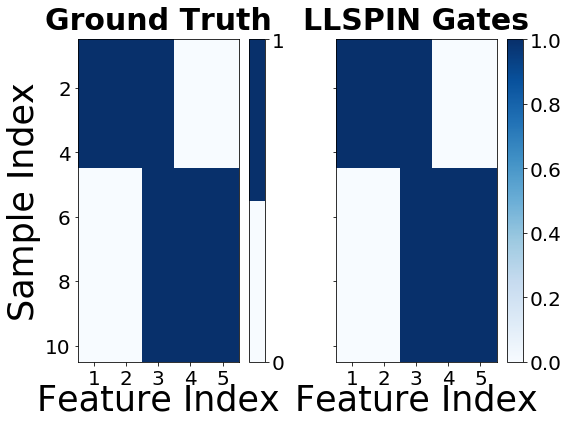

In [24]:
fig, axes = plt.subplots(1, 2,sharex=False, sharey=True,figsize=(8, 6))

sorted_order = np.concatenate((np.where(train_label == 1)[0],np.where(train_label == 2)[0]))

im1 = axes[0].imshow(ref_feat_mat_train[sorted_order,:].astype(int),aspect='auto',cmap=cmap, norm=norm)
axes[0].set_title("Ground Truth",fontsize=title_size,fontweight="bold",pad=title_pad)
axes[0].set_ylabel("Sample Index",fontsize=ylabel_size)
axes[0].set_yticks([1,3,5,7,9])
axes[0].set_yticklabels([2,4,6,8,10],fontsize=ytick_size)
axes[0].set_xticks(list(range(5)))
axes[0].set_xticklabels(list(range(1,6)),fontsize=xtick_size)
axes[0].set_xlabel("Feature Index",fontsize=xlabel_size,labelpad=-5)

cbar = fig.colorbar(im1,ax=axes[0], cmap=cmap, norm=norm, boundaries=bounds, ticks=[0, 1])
cbar.ax.tick_params(labelsize=colorbar_tick_size)

im2 = axes[1].imshow(gate_mat_train[sorted_order,:],aspect='auto',cmap=cmap)
axes[1].set_title("LLSPIN Gates",fontsize=title_size,fontweight="bold",pad=title_pad)
axes[1].set_yticks([1,3,5,7,9])
axes[1].set_yticklabels([2,4,6,8,10],fontsize=ytick_size)
axes[1].set_xticks(list(range(5)))
axes[1].set_xticklabels(list(range(1,6)),fontsize=xtick_size)
axes[1].set_xlabel("Feature Index",fontsize=xlabel_size,labelpad=-5)

cbar = fig.colorbar(im2,ax=axes[1])
cbar.ax.tick_params(labelsize=colorbar_tick_size)

plt.tight_layout()

### Comparing the test gates

In [25]:
gate_mat_test = best_model.get_prob_alpha(X_test)

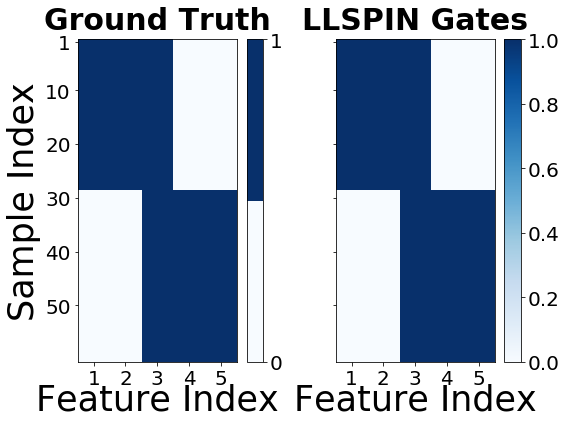

In [27]:
fig, axes = plt.subplots(1, 2,sharex=False, sharey=True,figsize=(8, 6))

fig.subplots_adjust(bottom=0.01)

sorted_order_test = np.concatenate((np.where(test_label == 1)[0],np.where(test_label == 2)[0]))

im1 = axes[0].imshow(ref_feat_mat_test[sorted_order_test,:].astype(int),aspect='auto',cmap=cmap, norm=norm)
axes[0].set_title("Ground Truth",fontsize=title_size,fontweight="bold",pad=title_pad)
axes[0].set_ylabel("Sample Index",fontsize=ylabel_size)
axes[0].set_yticks([0,9,19,29,39,49])
axes[0].set_yticklabels([1,10,20,30,40,50],fontsize=ytick_size)
axes[0].set_xticks(list(range(5)))
axes[0].set_xticklabels(list(range(1,6)),fontsize=xtick_size)
axes[0].set_xlabel("Feature Index",fontsize=xlabel_size,labelpad=-5)
cbar = fig.colorbar(im1,ax=axes[0], cmap=cmap, norm=norm, boundaries=bounds, ticks=[0, 1])
cbar.ax.tick_params(labelsize=colorbar_tick_size)
    
im2 = axes[1].imshow(gate_mat_test[sorted_order_test,:],aspect='auto',cmap=cmap)
axes[1].set_title("LLSPIN Gates",fontsize=title_size,fontweight="bold",pad=title_pad)
axes[1].set_yticks([0,9,19,29,39,49])
axes[1].set_yticklabels([1,10,20,30,40,50],fontsize=ytick_size)
axes[1].set_xticks(list(range(5)))
axes[1].set_xticklabels(list(range(1,6)),fontsize=xtick_size)
axes[1].set_xlabel("Feature Index",fontsize=xlabel_size,labelpad=-5)
    
cbar = fig.colorbar(im2,ax=axes[1])
cbar.ax.tick_params(labelsize=colorbar_tick_size)

plt.tight_layout()